In [1]:
import os
os.chdir('../../modules/')

In [41]:
import pickle
import shutil
import imageio
from util.util import *
from util.losses import *
from util.pred_blocks import ConvEncoder, GRUDecoder
from likelihood_predictor import PlastPredictor
from vae_generator import PlastVAEGen
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from rdkit import Chem
from rdkit.Chem.rdmolops import SanitizeMol

In [3]:
%load_ext autoreload
%autoreload 2

import IPython.display as Disp
np.set_printoptions(suppress=True)

### Best Run Analysis

In [4]:
df = pd.read_csv('run_data/logs/log_GRUGRU_prop_pred_1mil.txt')

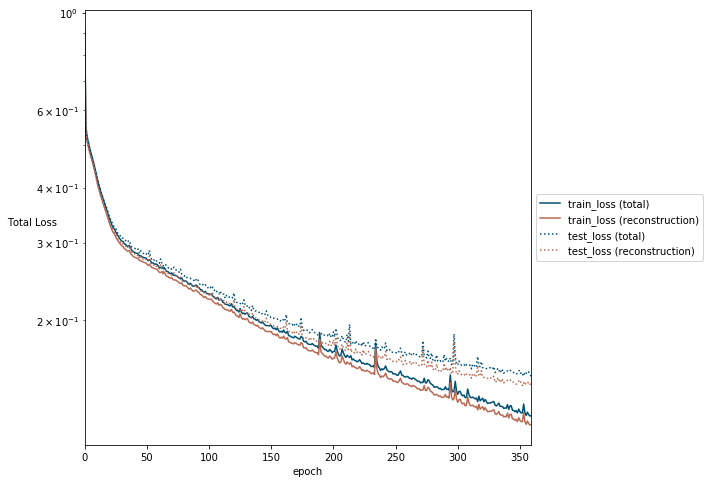

In [5]:
colors = ['#005073', '#B86953', '#932191', '#90041F', '#0F4935']

plt.figure(figsize=(10,8))
ax = plt.subplot(111)

df[df.data_type == 'train'].groupby('epoch').mean()['tot_loss'].plot(label='train_loss (total)',
                                                                       c=colors[0])
df[df.data_type == 'train'].groupby('epoch').mean()['bce_loss'].plot(label='train_loss (reconstruction)',
                                                                       c=colors[1])
# df[df.data_type == 'train'].groupby('epoch').mean()['kld_loss'].plot(label='train_loss (variational)',
#                                                                        c=colors[2])
# df[df.data_type == 'train'].groupby('epoch').mean()['pred_loss'].plot(label='train_loss (property prediction)',
#                                                                        c=colors[3])
df[df.data_type == 'test'].groupby('epoch').mean()['tot_loss'].plot(label='test_loss (total)',
                                                                       ls=':',
                                                                       c=colors[0])
df[df.data_type == 'test'].groupby('epoch').mean()['bce_loss'].plot(label='test_loss (reconstruction)',
                                                                       ls=':',
                                                                       c=colors[1])
# df[df.data_type == 'test'].groupby('epoch').mean()['kld_loss'].plot(label='test_loss (variational)',
#                                                                        ls=':',
#                                                                        c=colors[2])
# df[df.data_type == 'test'].groupby('epoch').mean()['pred_loss'].plot(label='test_loss (property prediction)',
#                                                                        ls=':',
#                                                                        c=colors[3])
# df1[df1.data_type == 'test'].groupby('epoch').mean()['naive_loss'].plot(label='val_loss')
# ax.axhline(loss_goals(1, 27), c='red', ls=':', label='No better than random', alpha=0.5)
# ax.axhline(loss_goals(5, 27), c='orange', ls=':', label='5x better than random', alpha=0.5)
# ax.axhline(loss_goals(10, 27), c='yellow', ls=':', label='10x better than random', alpha=0.5)
# ax.axhline(loss_goals(20, 27), c='green', ls=':', label='20x better than random', alpha=0.5)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Total Loss', rotation='horizontal')
plt.yscale('log')
plt.show()

### Load Model and Run Data

In [6]:
### Load model parameters
char_weights_gdb = np.load('util/char_weights_gdb.npy')
char_weights_orgpl = np.load('util/char_weights_orgpl.npy')
with open('util/char_dict.pkl', 'rb') as f:
    char_dict = pickle.load(f)
with open('util/org_dict.pkl', 'rb') as f:
    org_dict = pickle.load(f)
    
pvg = PlastVAEGen(params={'MAX_LENGTH': 180,
                          'BATCH_SIZE': 10,
                          'MODEL_CLASS': 'GRUGRU',
                          'ARCH_SIZE': 'large',
                          'CHAR_DICT': char_dict,
                          'ORG_DICT': org_dict,
                          'CHAR_WEIGHTS': char_weights_orgpl},
                          name='test')

In [7]:
pvg.load('checkpoints/latest_GRUGRU_prop_pred_1mil.ckpt', transfer=False, predict_property=True)

In [8]:
### Load data
org_data = pd.read_pickle('../database/vae_org.pkl').to_numpy()
org_smiles = list(org_data[:,0])
org_smiles = np.array([smi_tokenizer(smi) for smi in org_smiles])
org_ll = org_data[:,1]
org_encoded_smiles = np.zeros((org_data.shape[0], 180))
for i, sm in enumerate(org_smiles):
    org_encoded_smiles[i,:] = encode_smiles(sm, 180, pvg.params['CHAR_DICT'])

pl_data = pd.read_pickle('../database/vae_pl.pkl').to_numpy()
pl_smiles = list(pl_data[:,0])
pl_smiles = np.array([smi_tokenizer(smi) for smi in pl_smiles])
pl_ll = pl_data[:,1]
pl_encoded_smiles = np.zeros((pl_data.shape[0], 180))
for i, sm in enumerate(pl_smiles):
    pl_encoded_smiles[i,:] = encode_smiles(sm, 180, pvg.params['CHAR_DICT'])

In [9]:
### Load model predictions
org_mu = np.load('run_data/predictions/org_mu.npy')
org_logvar = np.load('run_data/predictions/org_logvar.npy')

pl_mu = np.load('run_data/predictions/pl_mu.npy')
pl_logvar = np.load('run_data/predictions/pl_logvar.npy')

In [10]:
### Sort indices by plasticizer likelihood
pl_sort = np.argsort(pl_ll)[::-1]
org_sort = np.argsort(org_ll)[::-1]

### Testing Molecule Generation

In [28]:
# Plasticizer 1
pl_idx = 0
top_plast = ''.join(pl_smiles[pl_sort[pl_idx]]).replace('_', '')
top_plast_mu = pl_mu[pl_sort[pl_idx]]
top_plast_logvar = pl_logvar[pl_sort[pl_idx]]
top_plast_z = pvg.network.encoder.reparameterize(torch.tensor(top_plast_mu), torch.tensor(top_plast_logvar)).numpy()
top_plast_decode = decode_z(top_plast_z, pvg, temp=0.5)

# Plasticizer 2
pl_idx_2 = 2
top_plast_2 = ''.join(pl_smiles[pl_sort[pl_idx_2]]).replace('_', '')
top_plast_mu_2 = pl_mu[pl_sort[pl_idx_2]]
top_plast_logvar_2 = pl_logvar[pl_sort[pl_idx_2]]
top_plast_z_2 = pvg.network.encoder.reparameterize(torch.tensor(top_plast_mu_2), torch.tensor(top_plast_logvar_2)).numpy()
top_plast_decode_2 = decode_z(top_plast_z_2, pvg, temp=0.5)
top_plast, top_plast_2

('CCCCCCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2',
 'CCCCOC(=O)COC(=O)C1=CC=CC=C1C(=O)OCCCC')

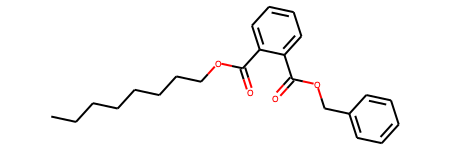

In [32]:
Chem.MolFromSmiles(top_plast_decode)

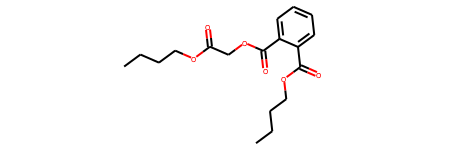

In [33]:
Chem.MolFromSmiles(top_plast_decode_2)

In [53]:
n_interpolation_points = 9
interp_intervals = np.linspace(0, 1, n_interpolation_points+2)[1:-1]
candidates = {}
candidate_smiles = {}
for i, interval in enumerate(interp_intervals):
    interp_p = slerp(top_plast_z, top_plast_z_2, interval)
    candidates[i] = []
    candidate_smiles[i] = []
    for _ in range(10):
        interp_decode = decode_z(interp_p, pvg, temp=0.5)
        candidate = Chem.MolFromSmiles(interp_decode)
        if candidate is not None and interp_decode not in candidate_smiles[i]:
            candidates[i].append(candidate)
            candidate_smiles[i].append(interp_decode)            

RDKit ERROR: [18:43:15] SMILES Parse Error: syntax error while parsing: CCCCCCCCCC((O)C1=C(=CC=C1C(=OOO)C2CCC=CCCC
RDKit ERROR: [18:43:15] SMILES Parse Error: Failed parsing SMILES 'CCCCCCCCCC((O)C1=C(=CC=C1C(=OOO)C2CCC=CCCC' for input: 'CCCCCCCCCC((O)C1=C(=CC=C1C(=OOO)C2CCC=CCCC'
RDKit ERROR: [18:43:15] SMILES Parse Error: syntax error while parsing: CCCCCCCCCC(=O)C1=C(=CC=C1C(==OOCC2CCC=CCCC
RDKit ERROR: [18:43:15] SMILES Parse Error: Failed parsing SMILES 'CCCCCCCCCC(=O)C1=C(=CC=C1C(==OOCC2CCC=CCCC' for input: 'CCCCCCCCCC(=O)C1=C(=CC=C1C(==OOCC2CCC=CCCC'
RDKit ERROR: [18:43:15] SMILES Parse Error: syntax error while parsing: CCCCCCCCCC(=O)C1=C(=CC=C1CC=(OOCCCCCC=CCCC
RDKit ERROR: [18:43:15] SMILES Parse Error: Failed parsing SMILES 'CCCCCCCCCC(=O)C1=C(=CC=C1CC=(OOCCCCCC=CCCC' for input: 'CCCCCCCCCC(=O)C1=C(=CC=C1CC=(OOCCCCCC=CCCC'
RDKit ERROR: [18:43:15] SMILES Parse Error: syntax error while parsing: CCCCCCCCCC(OO)C1=C==CC=C1C(==)OCC2CCC=CCCC
RDKit ERROR: [18:43:15] SMILES Parse Er

In [54]:
for k, v in candidates.items():
    print(k, len(v))

0 1
1 0
2 1
3 2
4 2
5 1
6 1
7 1
8 2


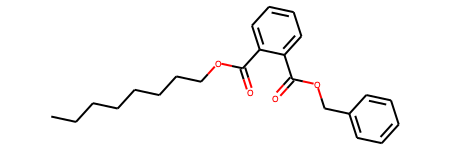

In [70]:
candidates[0][0]

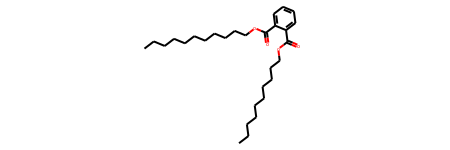

In [71]:
candidates[2][0]

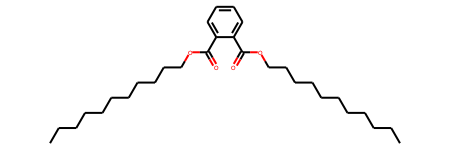

In [81]:
candidates[3][1]

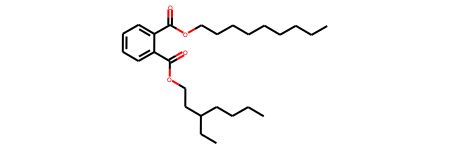

In [86]:
candidates[6][0]

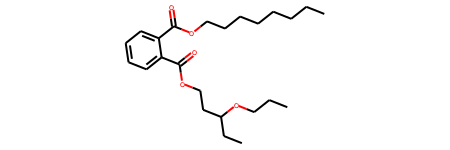

In [79]:
candidates[8][0]

In [72]:
candidate_smiles[2][0]

'CCCCCCCCCCCOC(=O)C1=CC=CC=C1C(=O)OCCCCCCCCCC'

In [87]:
for smile in pl_smiles:
    pl_smile = ''.join(smile).replace('_', '')
    if pl_smile == candidate_smiles[8][0]:
        print('ya')

### Viewing Generated Candidates

In [89]:
org_pl_smiles = np.load('../modules/candidate_smiles_w_org.npy', allow_pickle=True)
mols = []
for smile in org_pl_smiles:
    smile = ''.join(smile).replace('_', '')
    mol = Chem.MolFromSmiles(smile)
    SanitizeMol(mol)
    mols.append(mol)

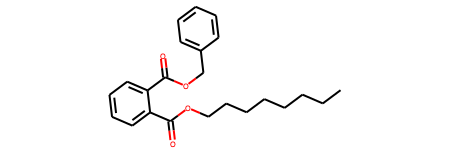

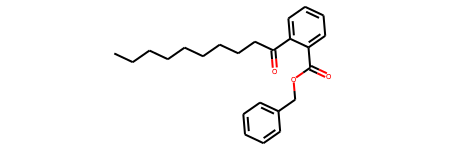

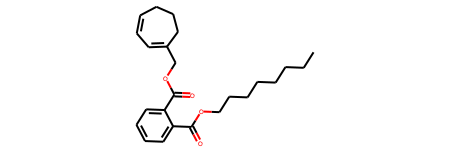

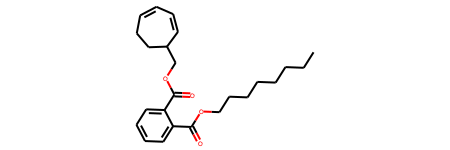

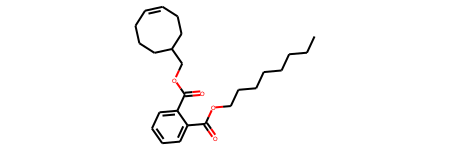

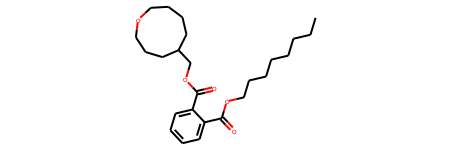

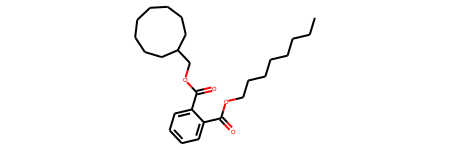

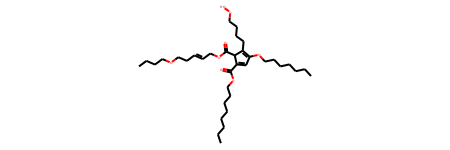

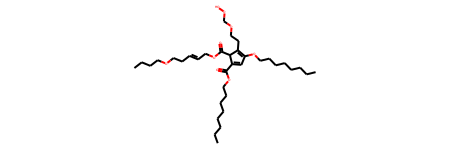

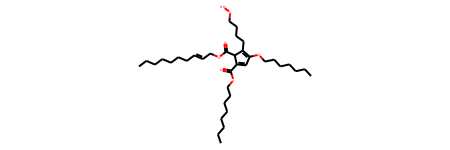

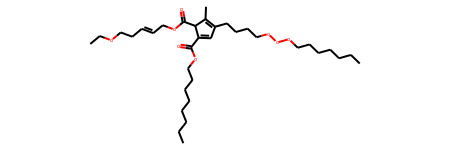

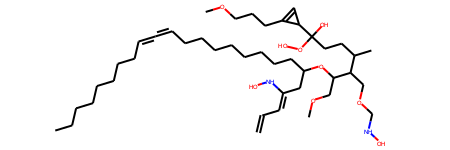

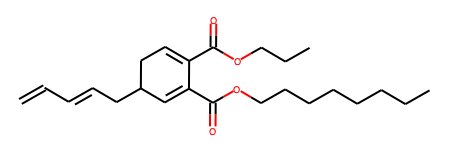

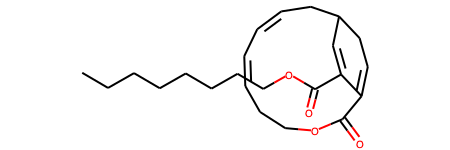

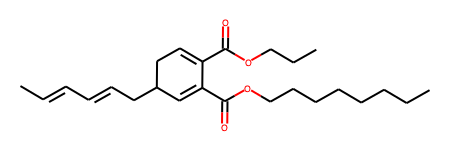

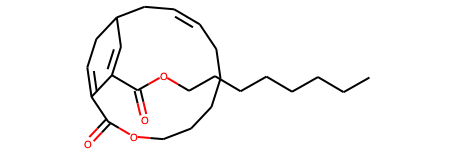

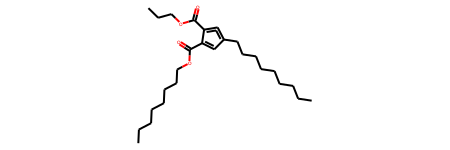

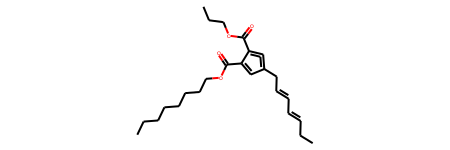

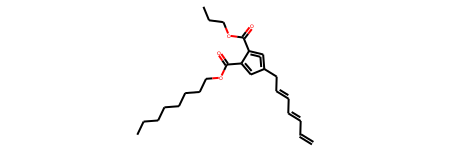

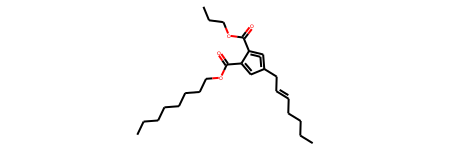

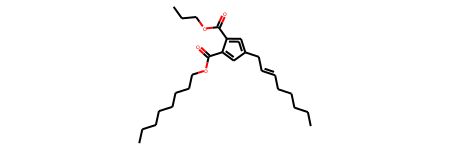

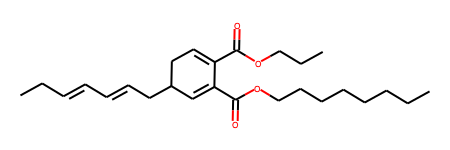

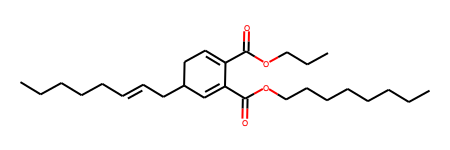

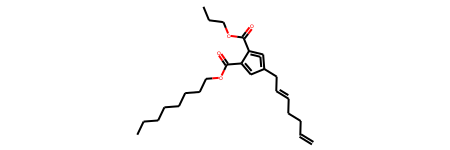

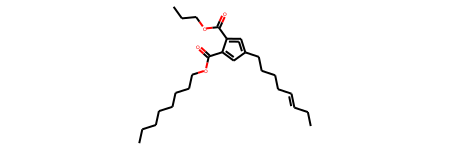

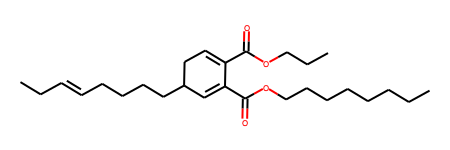

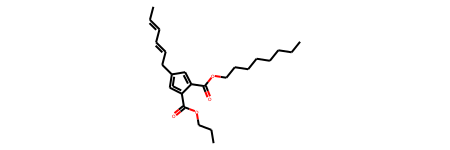

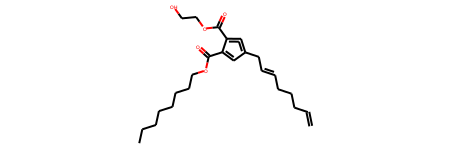

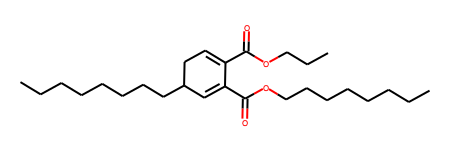

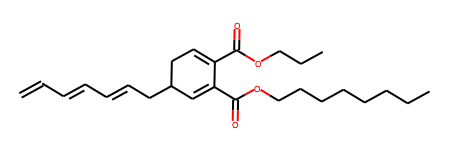

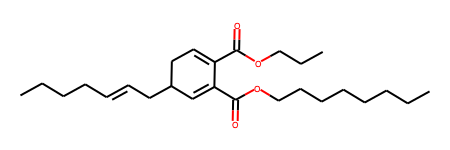

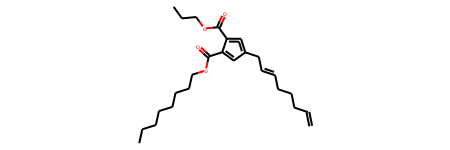

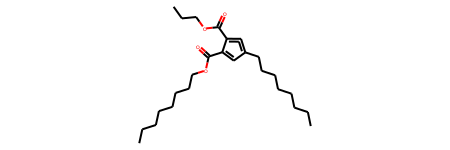

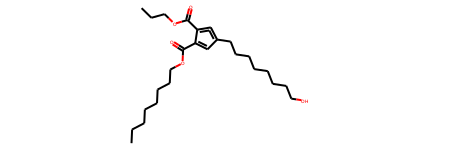

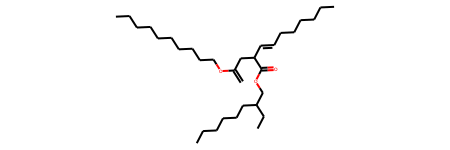

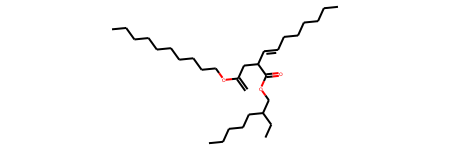

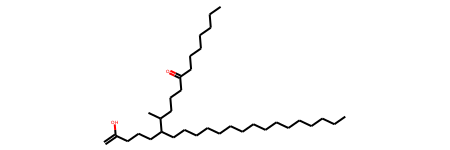

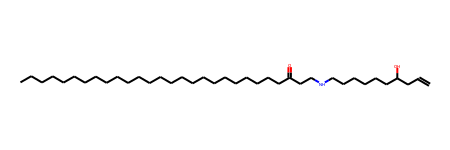

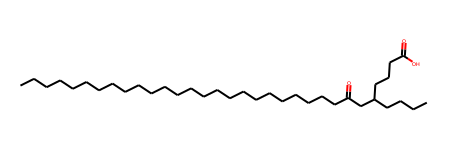

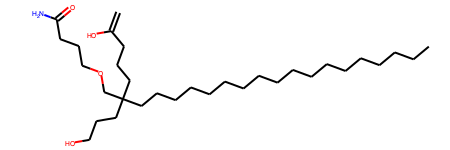

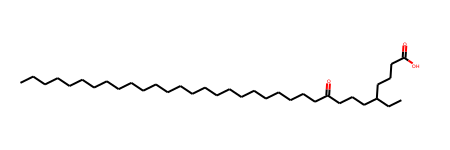

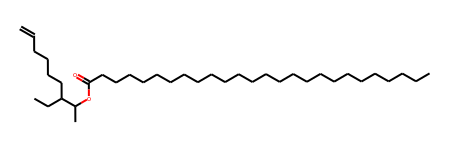

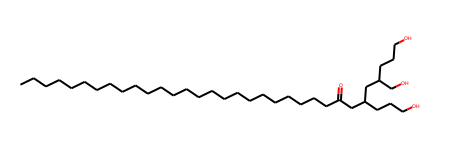

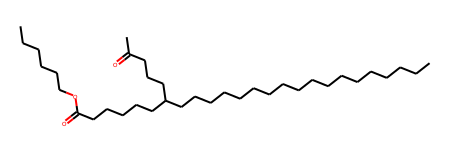

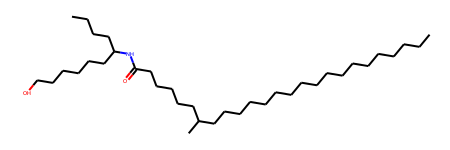

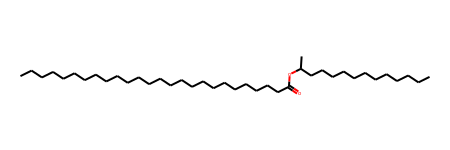

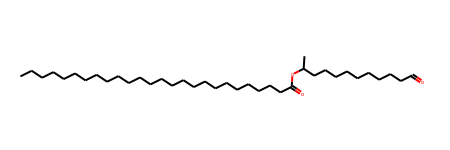

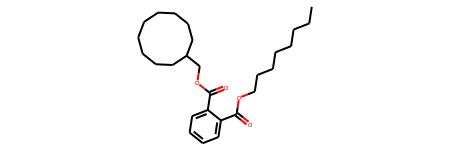

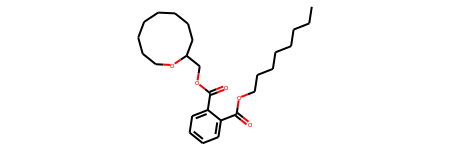

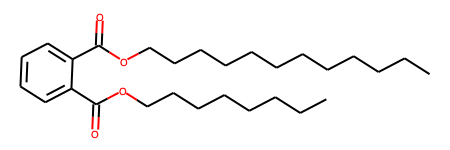

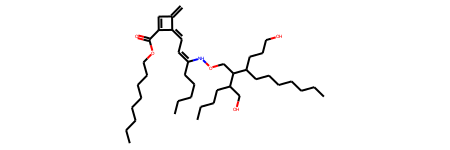

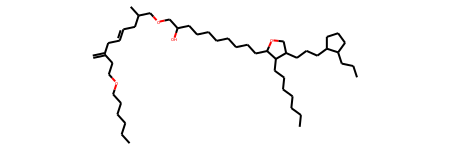

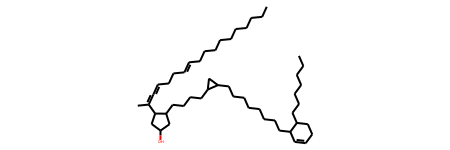

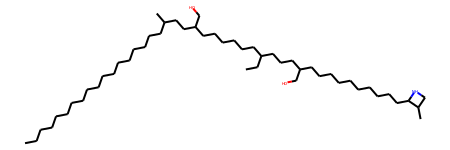

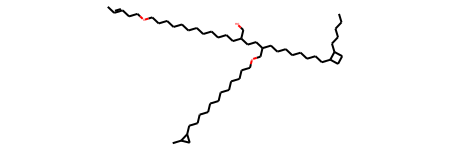

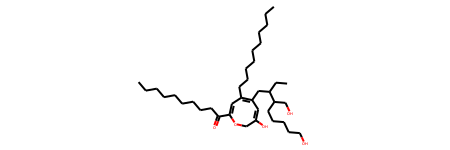

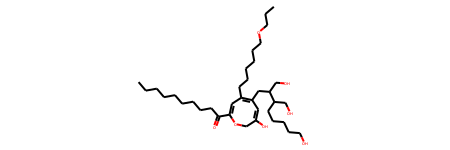

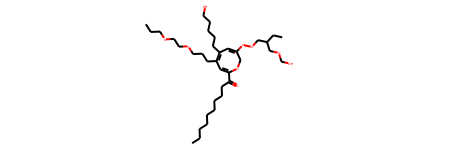

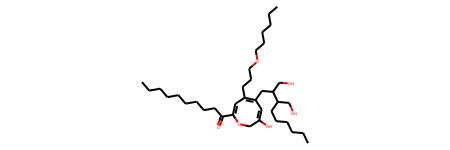

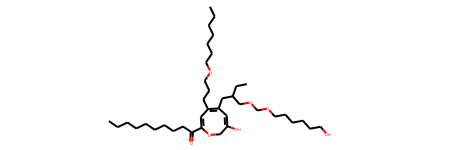

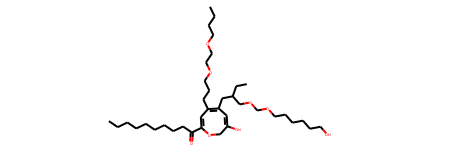

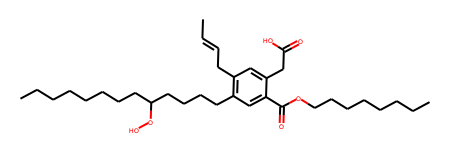

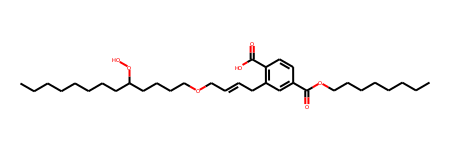

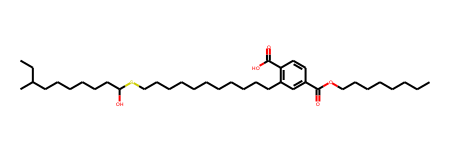

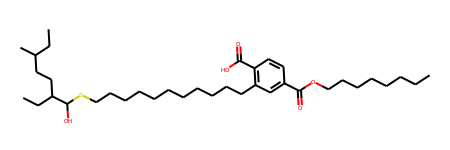

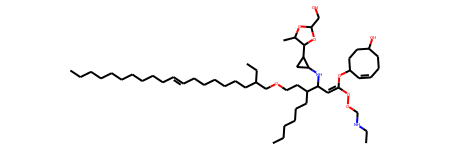

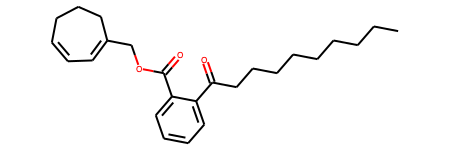

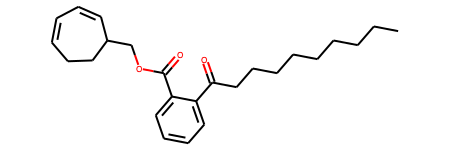

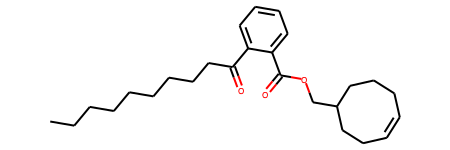

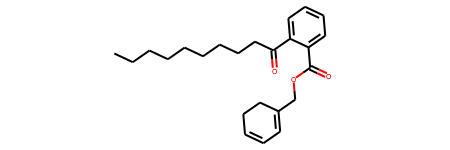

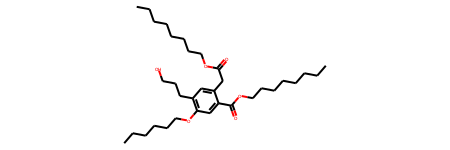

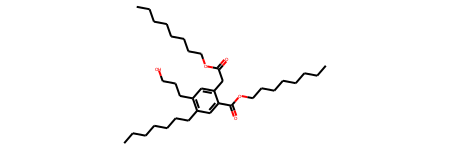

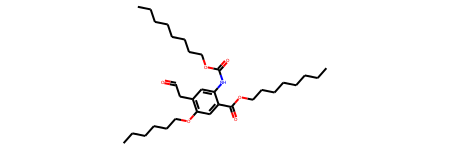

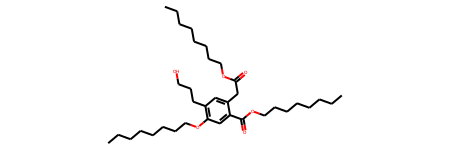

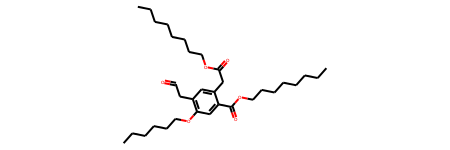

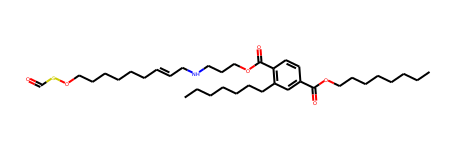

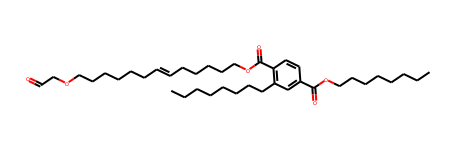

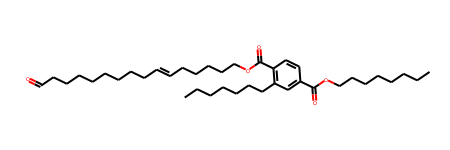

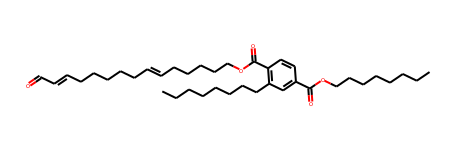

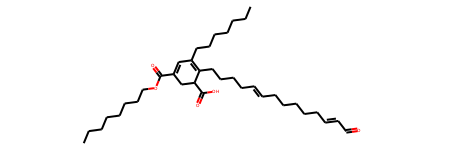

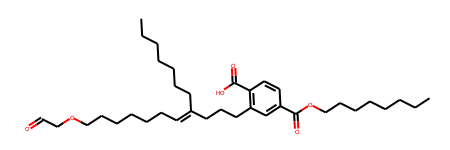

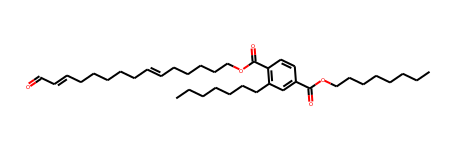

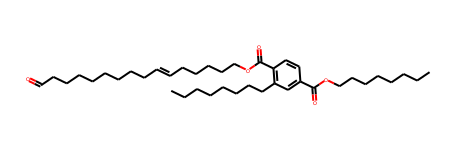

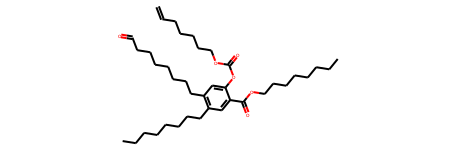

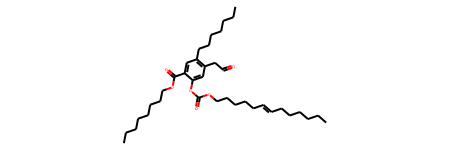

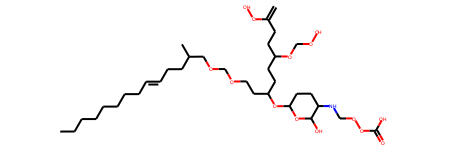

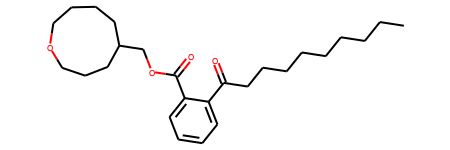

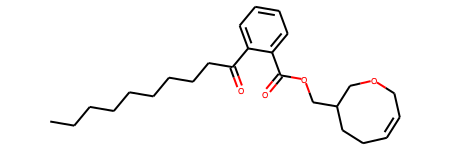

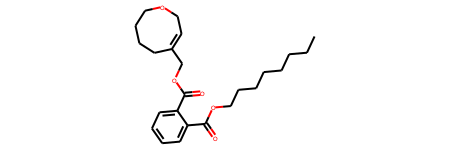

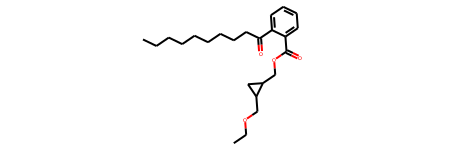

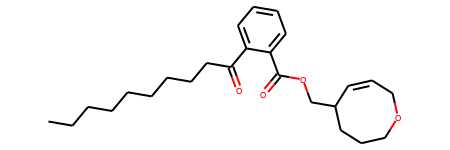

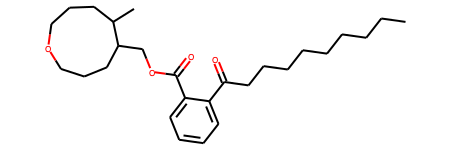

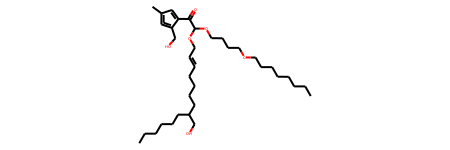

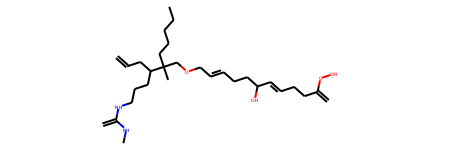

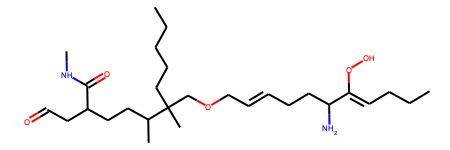

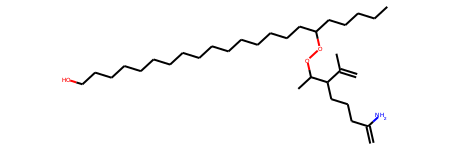

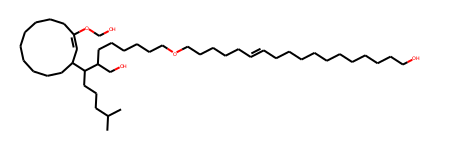

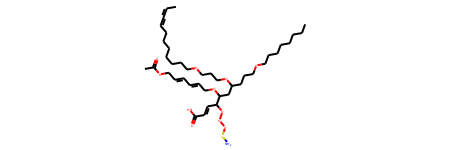

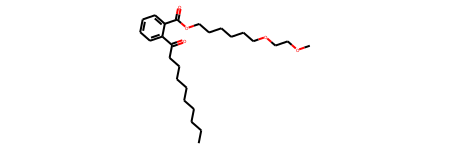

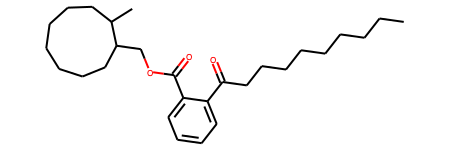

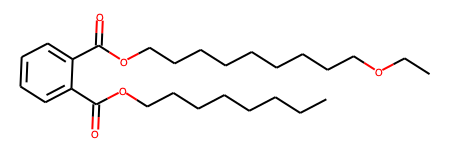

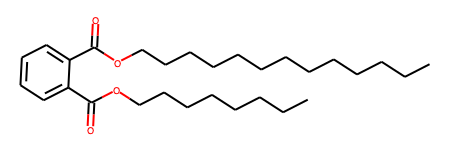

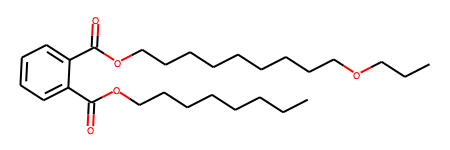

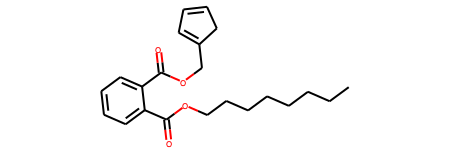

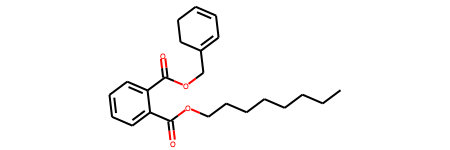

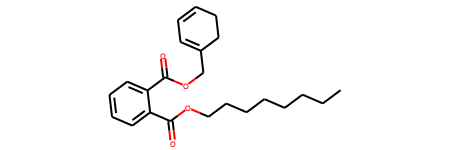

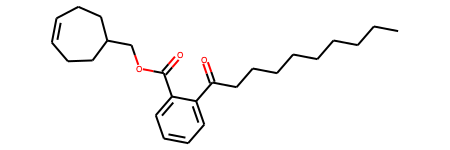

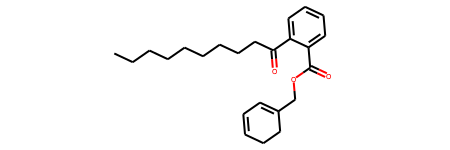

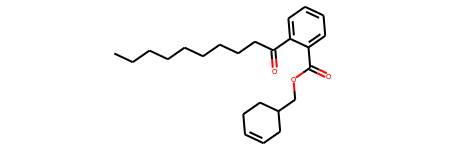

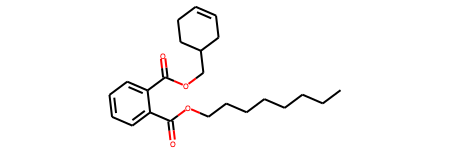

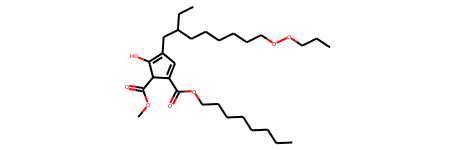

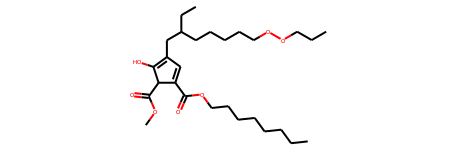

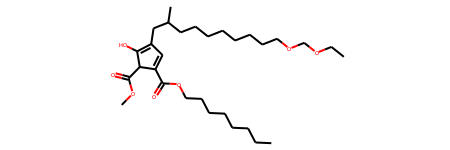

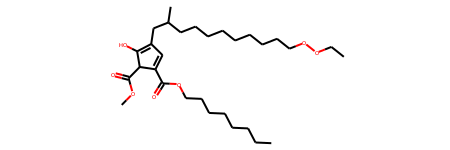

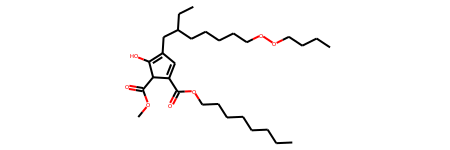

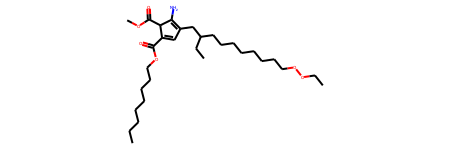

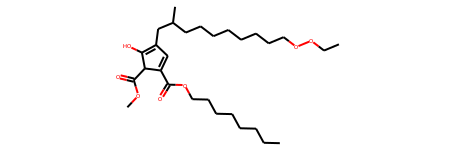

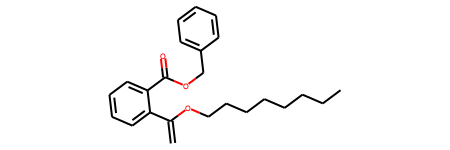

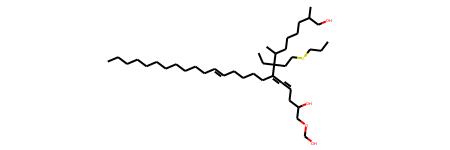

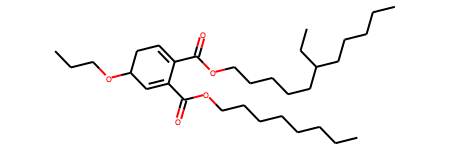

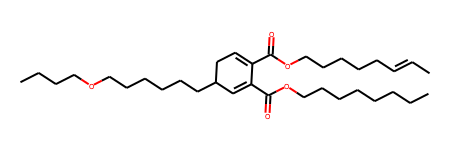

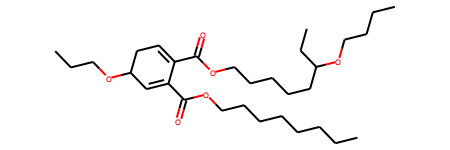

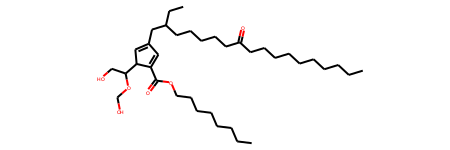

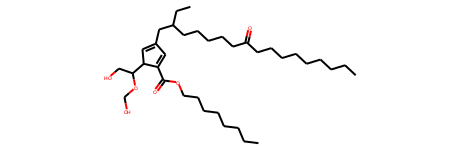

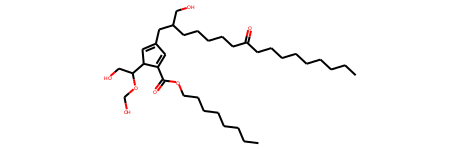

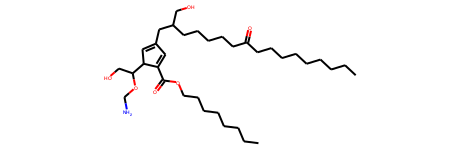

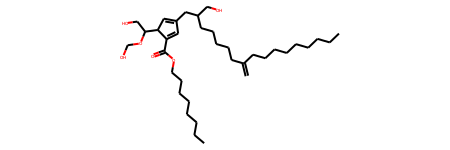

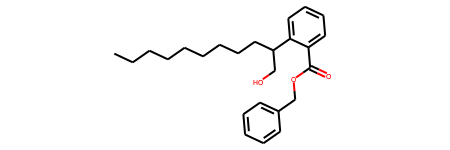

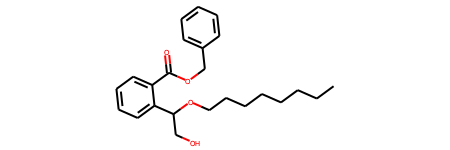

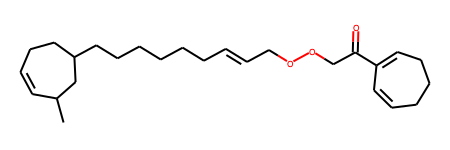

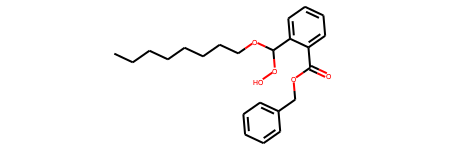

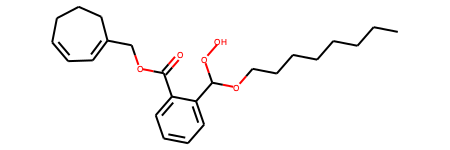

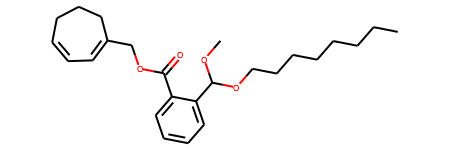

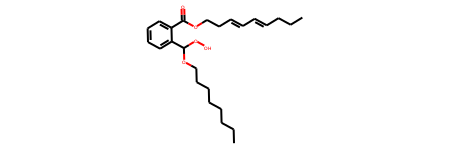

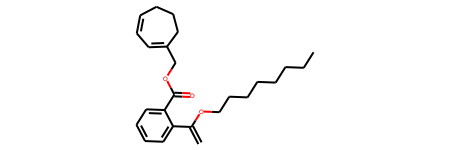

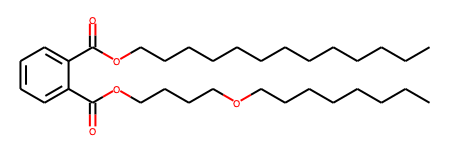

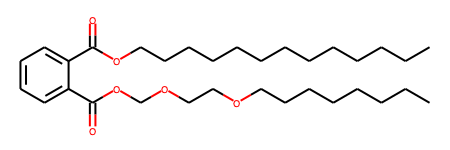

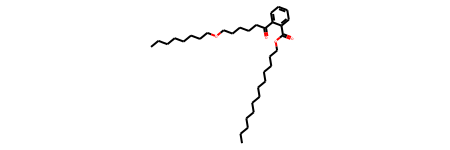

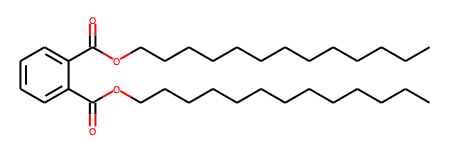

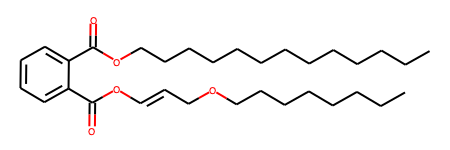

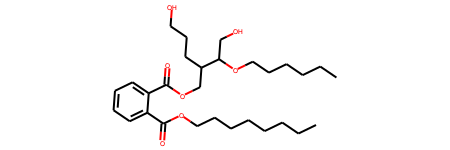

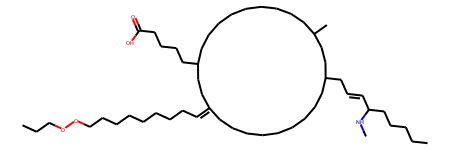

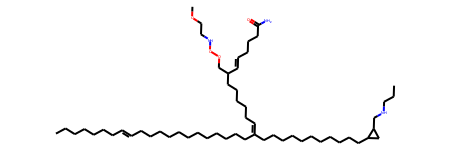

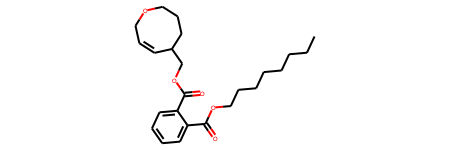

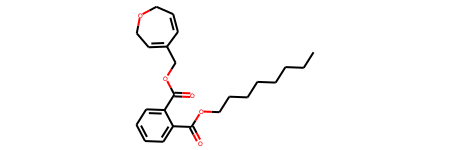

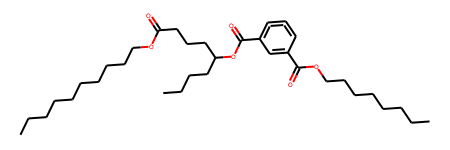

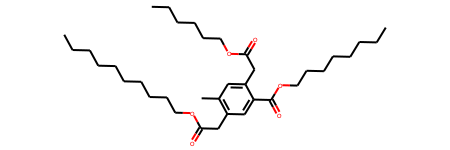

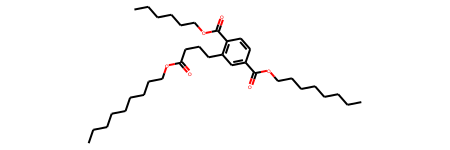

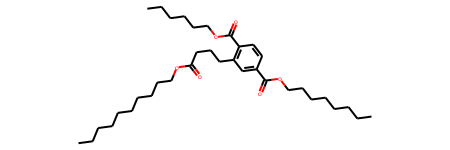

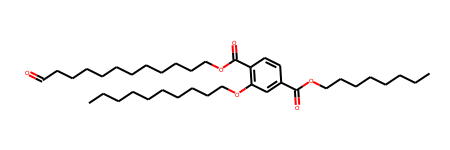

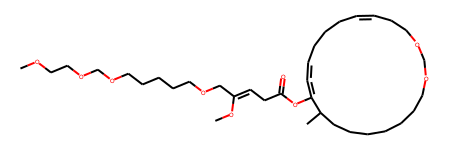

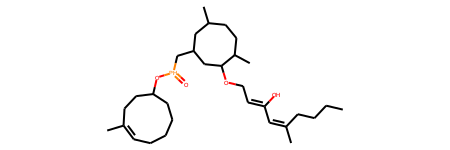

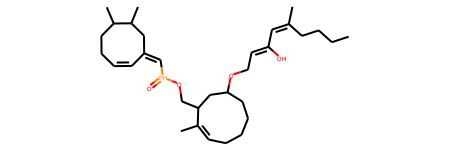

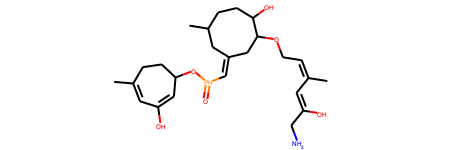

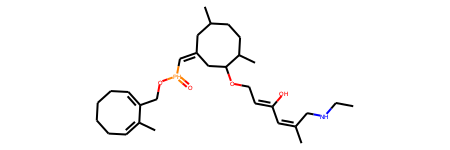

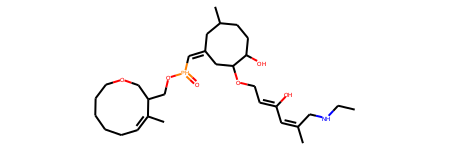

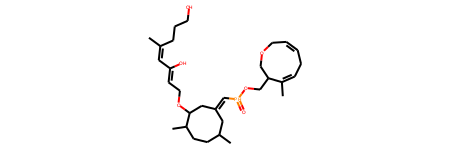

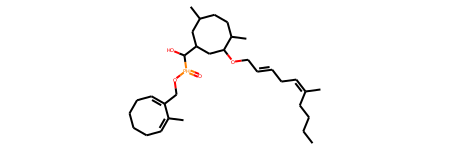

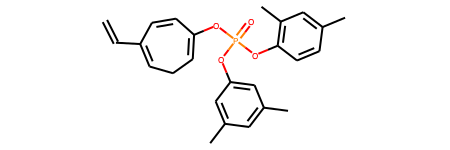

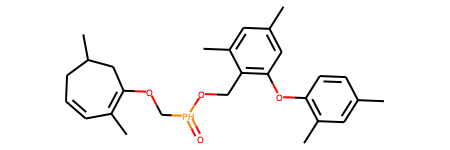

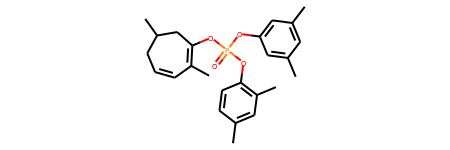

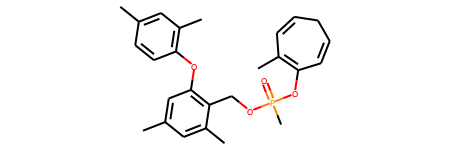

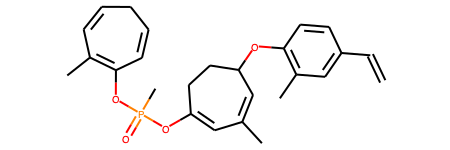

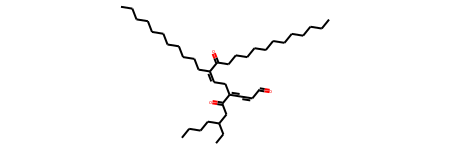

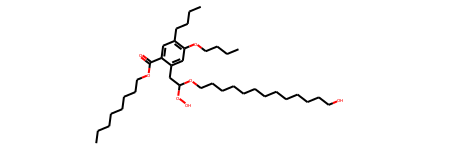

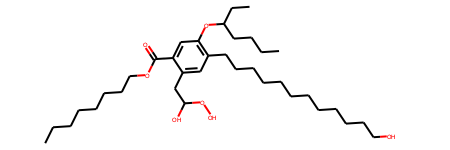

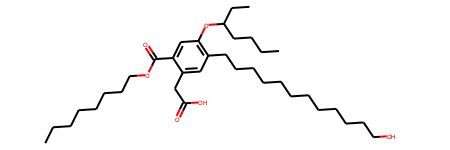

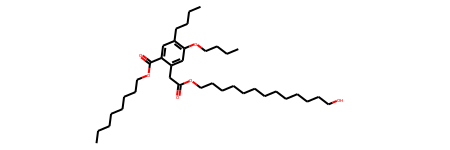

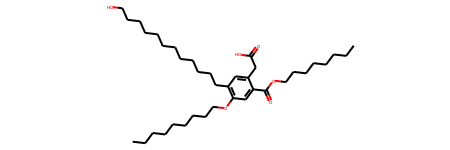

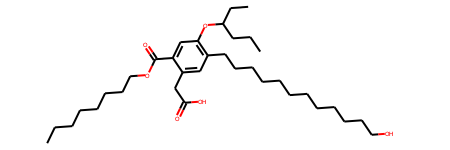

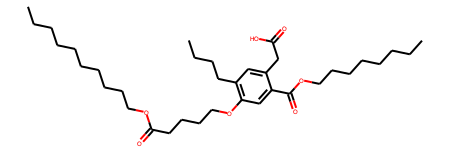

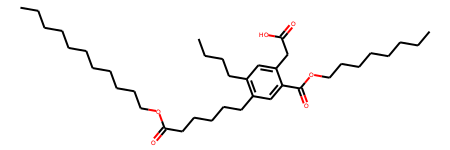

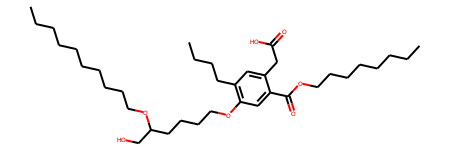

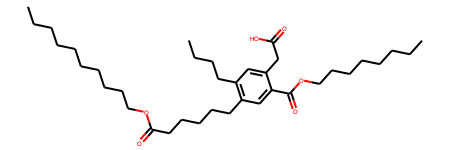

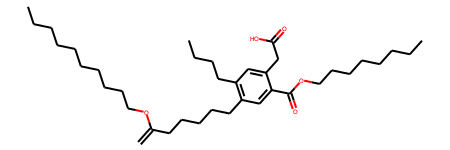

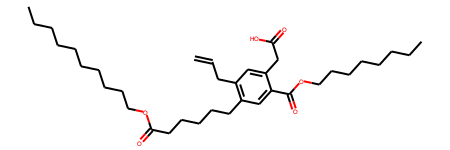

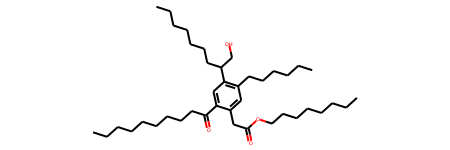

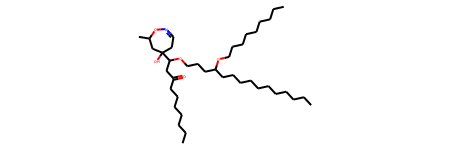

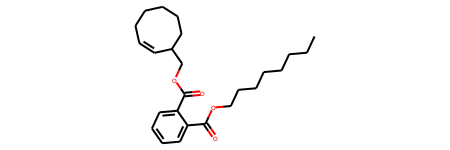

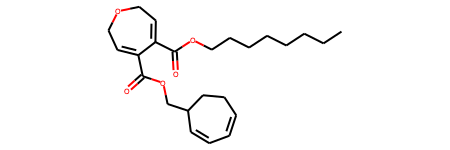

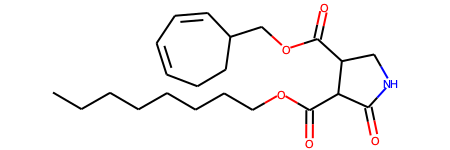

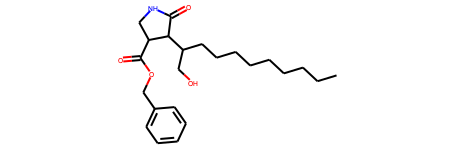

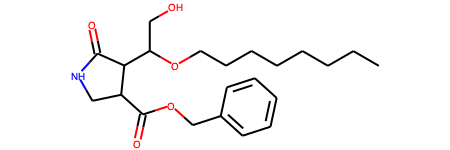

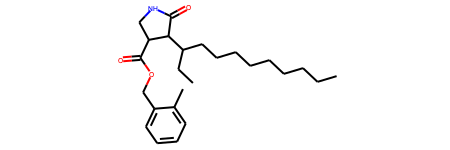

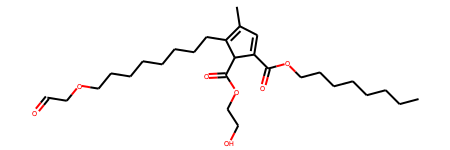

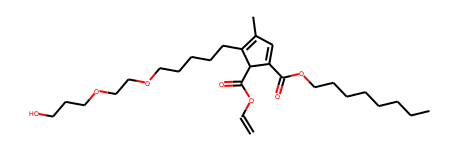

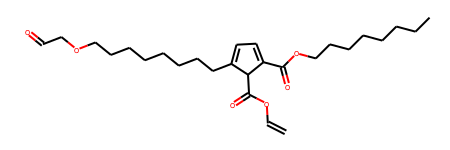

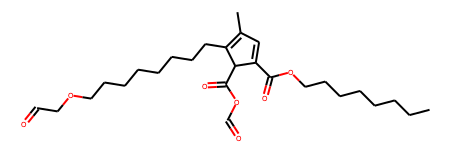

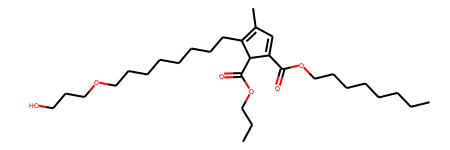

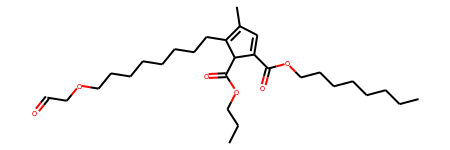

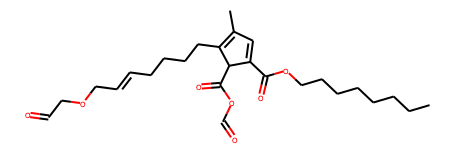

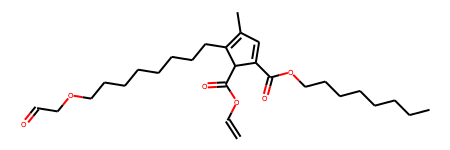

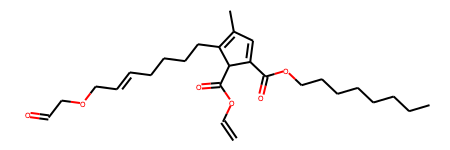

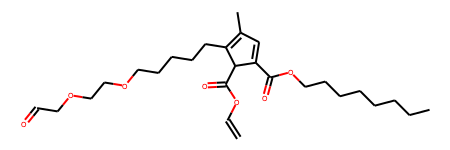

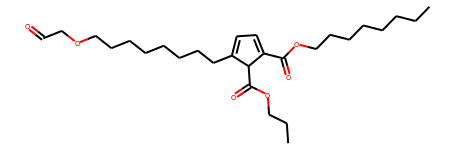

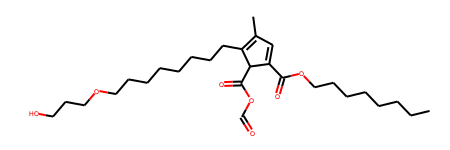

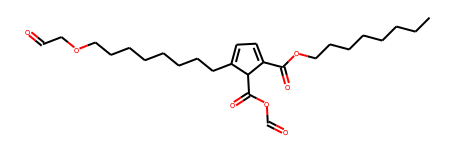

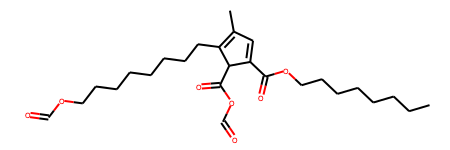

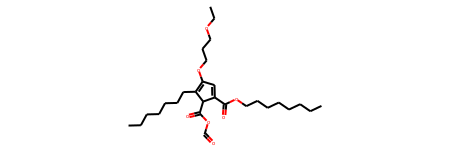

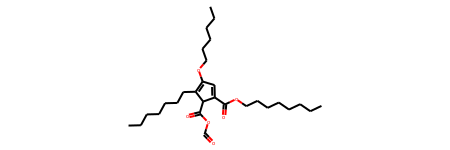

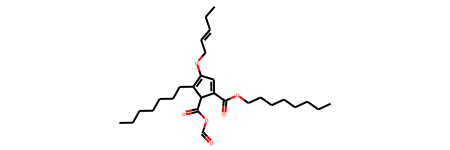

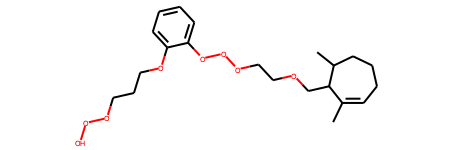

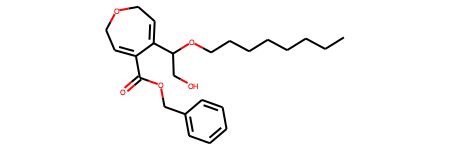

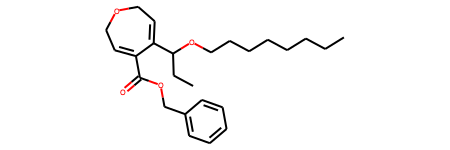

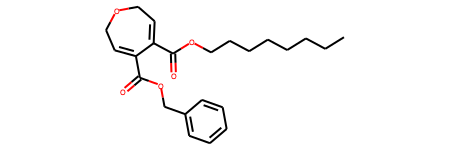

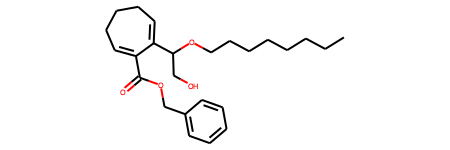

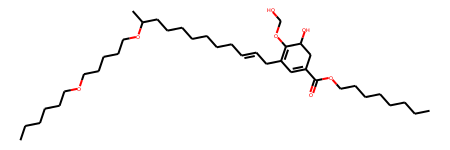

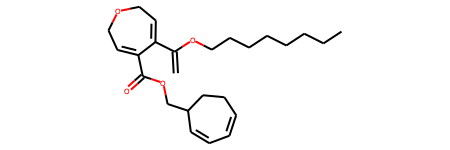

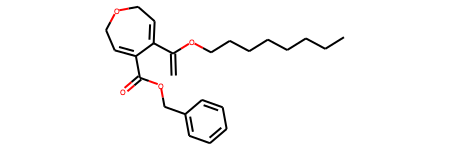

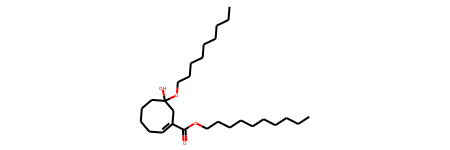

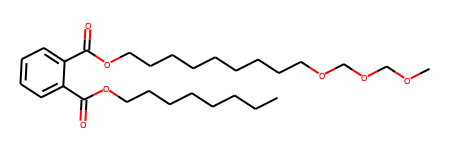

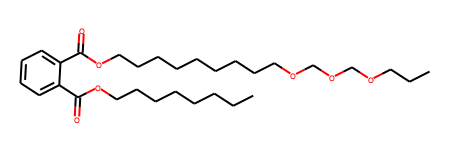

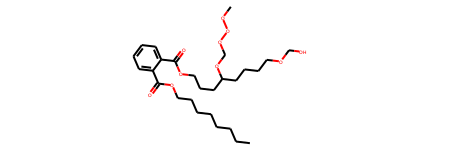

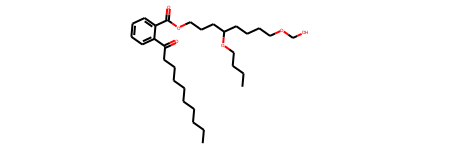

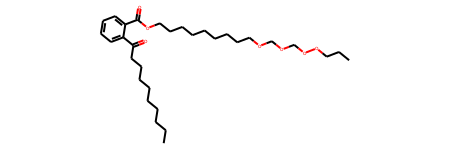

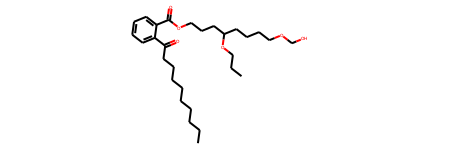

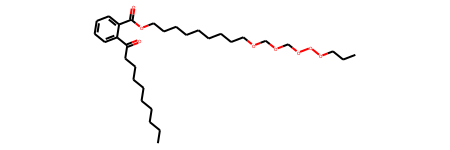

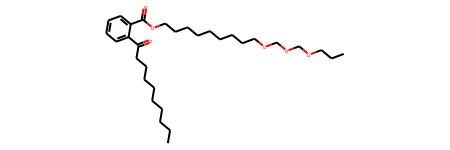

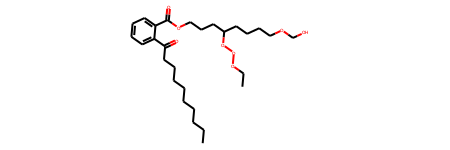

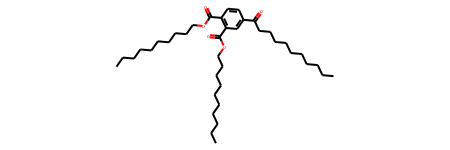

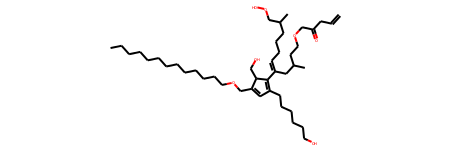

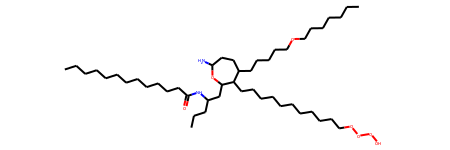

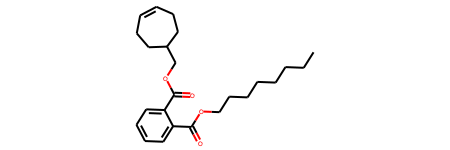

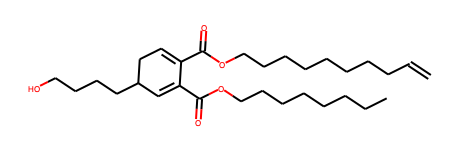

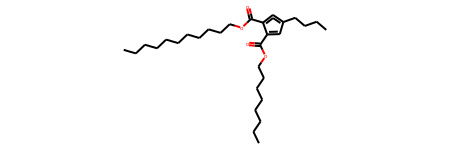

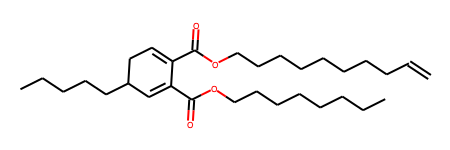

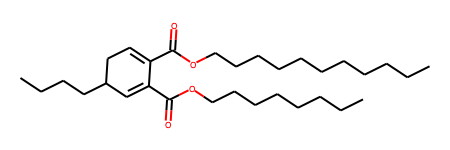

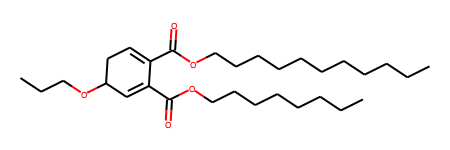

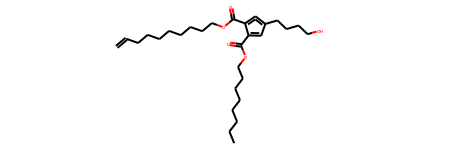

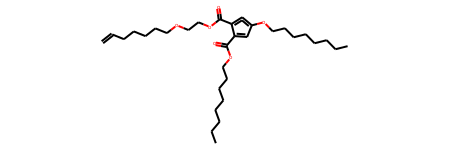

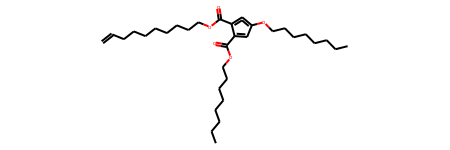

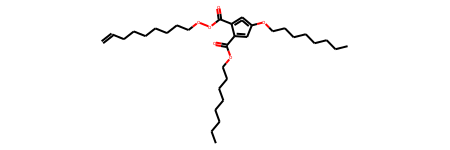

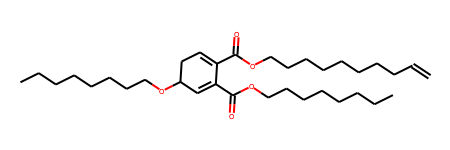

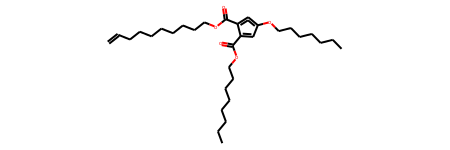

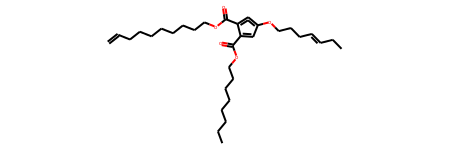

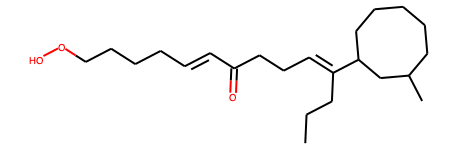

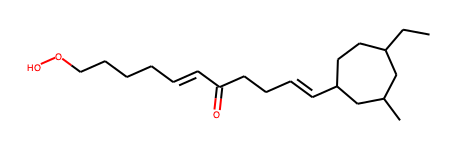

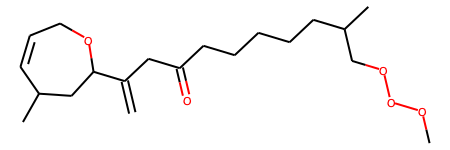

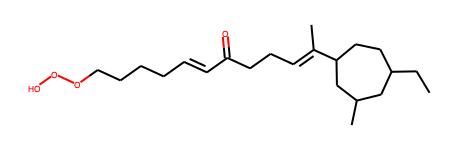

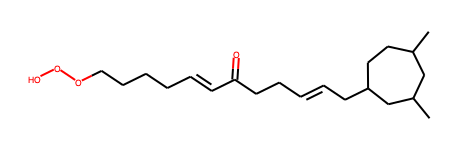

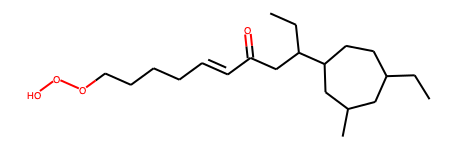

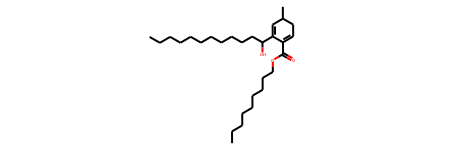

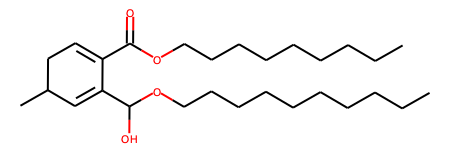

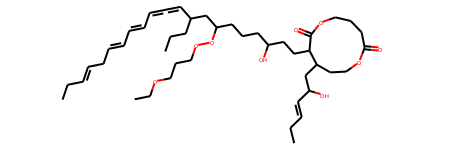

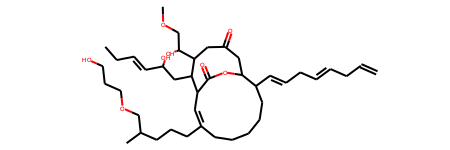

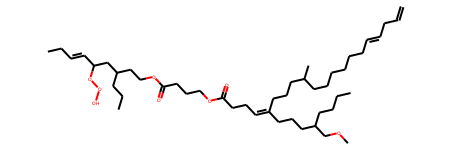

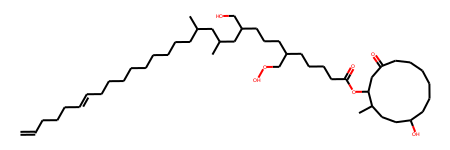

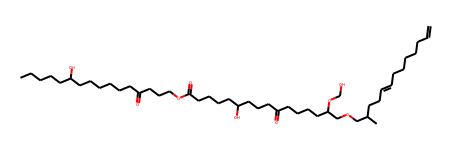

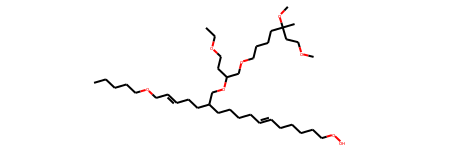

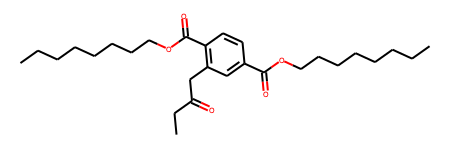

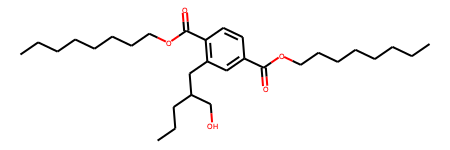

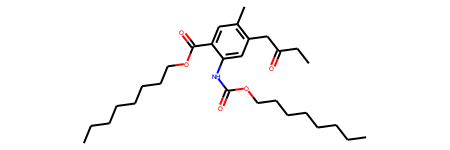

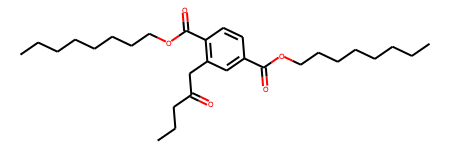

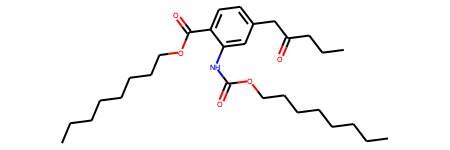

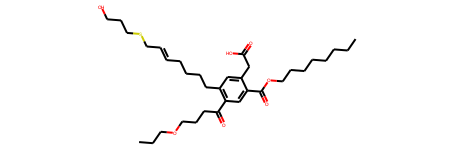

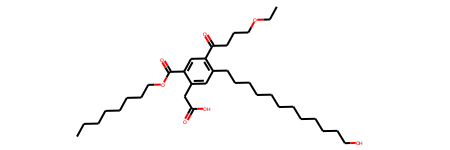

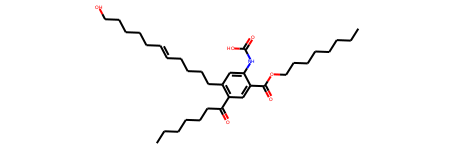

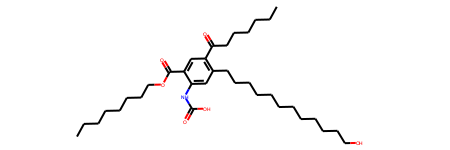

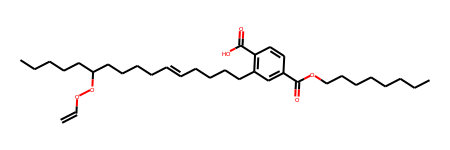

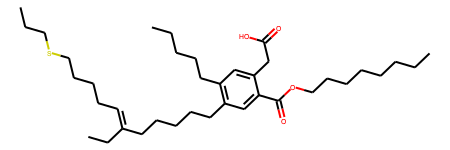

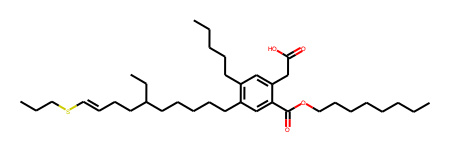

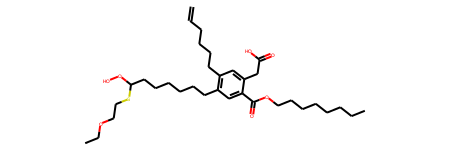

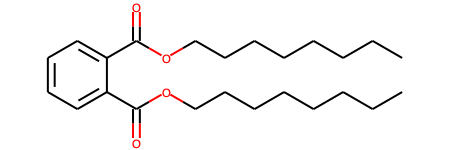

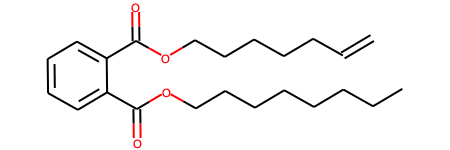

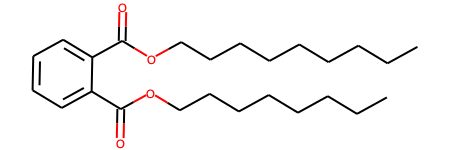

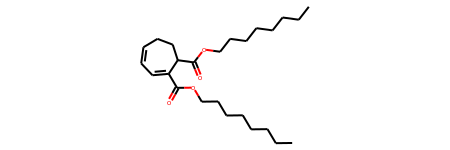

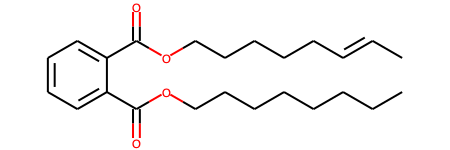

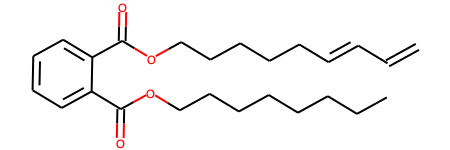

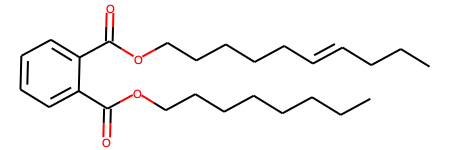

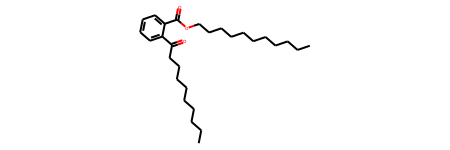

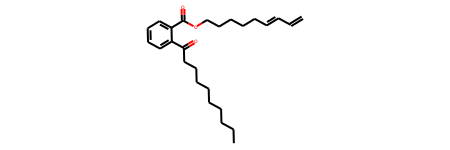

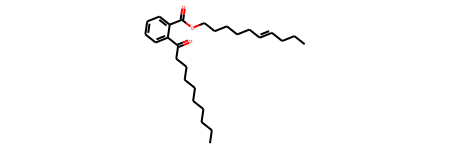

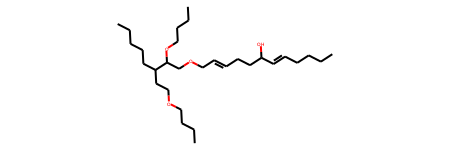

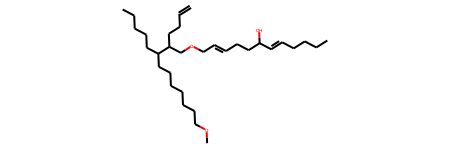

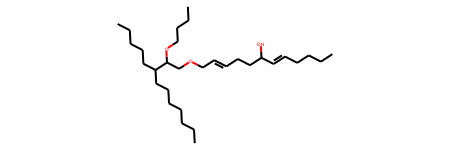

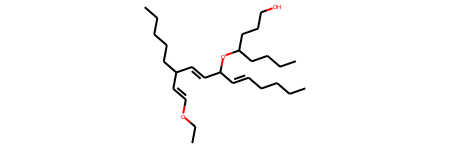

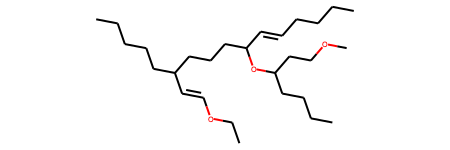

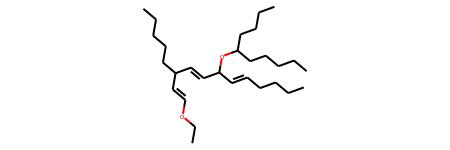

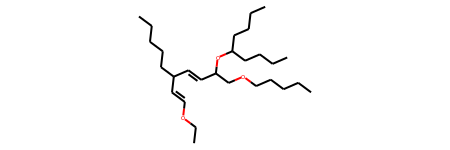

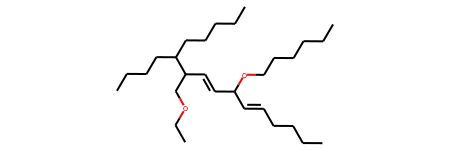

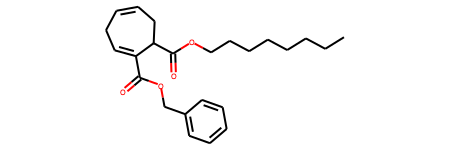

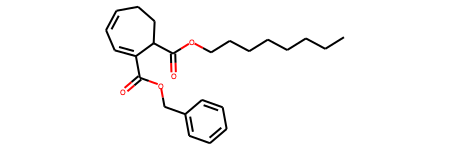

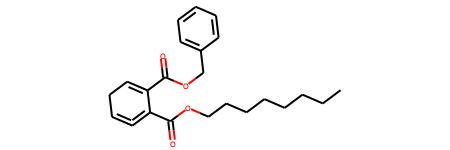

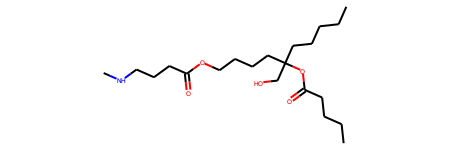

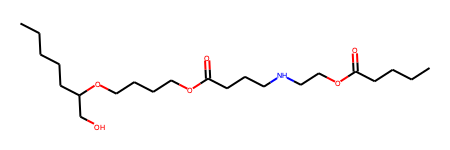

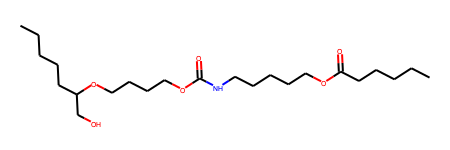

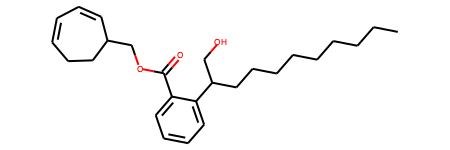

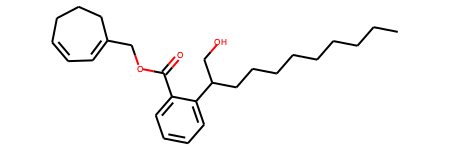

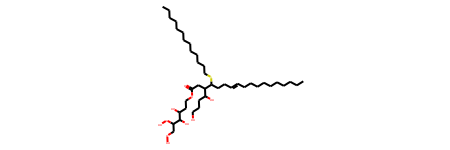

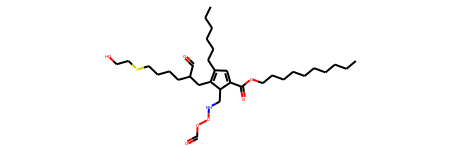

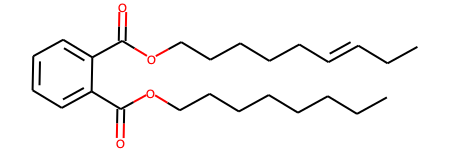

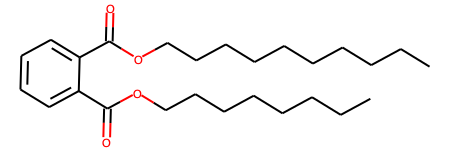

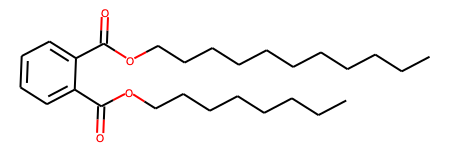

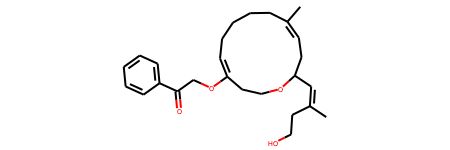

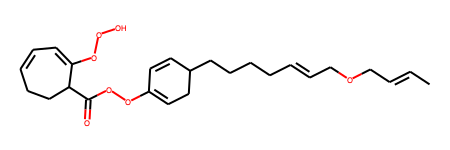

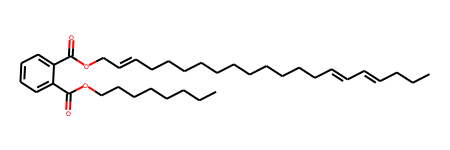

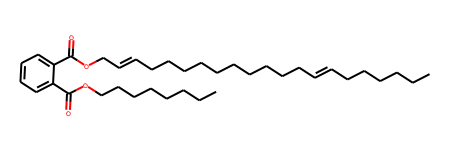

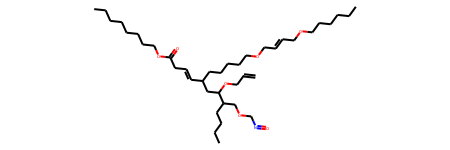

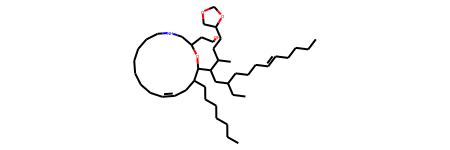

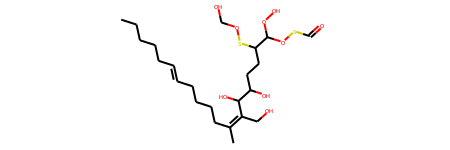

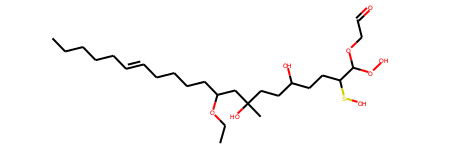

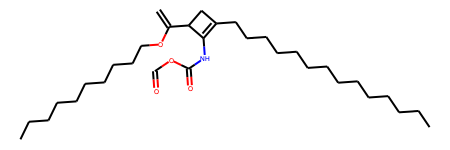

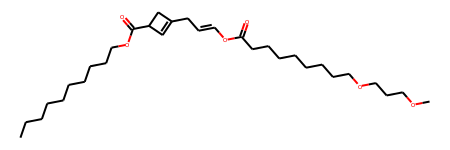

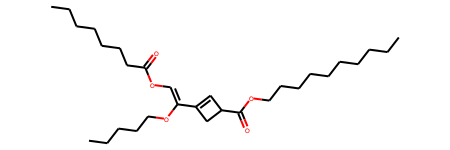

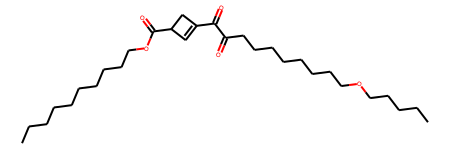

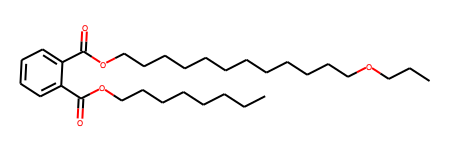

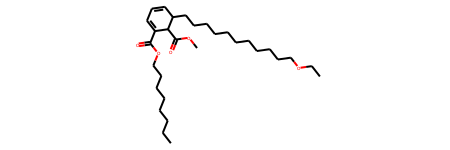

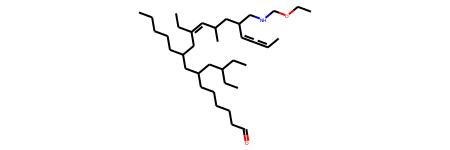

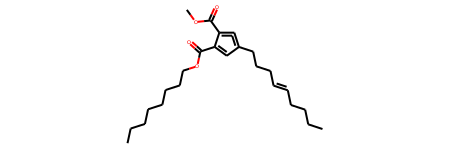

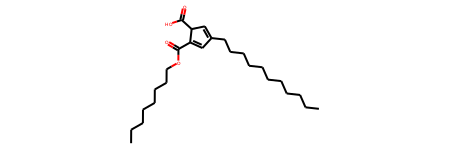

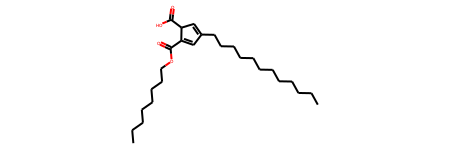

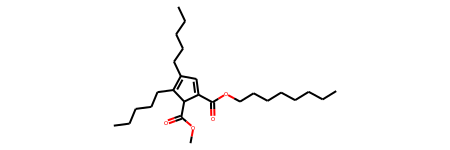

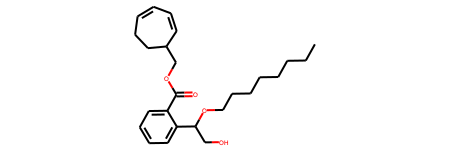

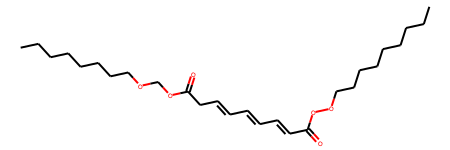

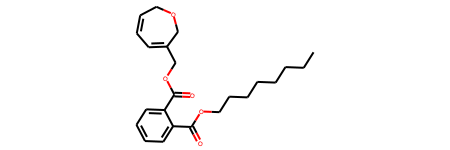

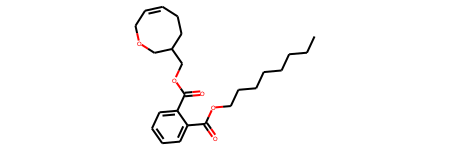

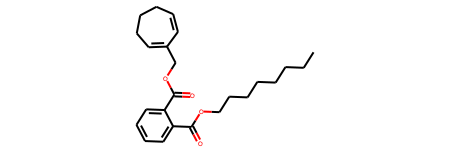

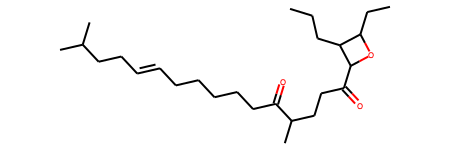

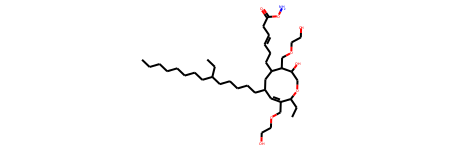

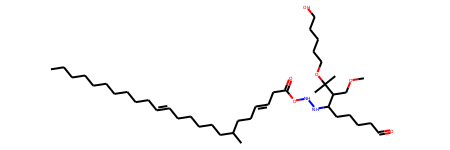

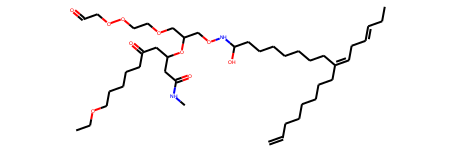

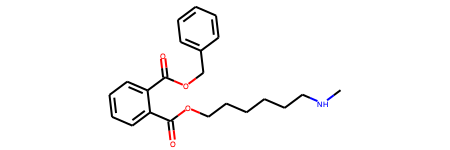

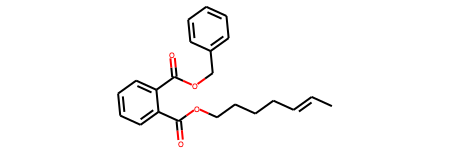

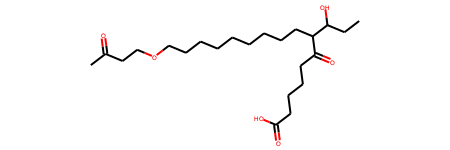

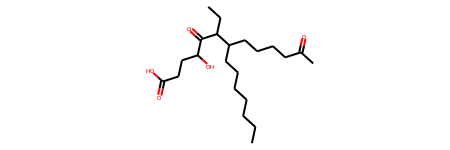

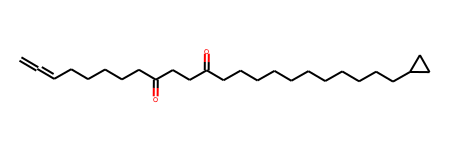

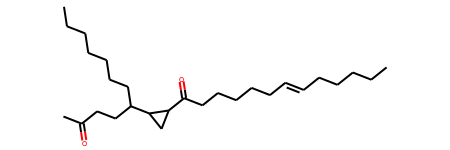

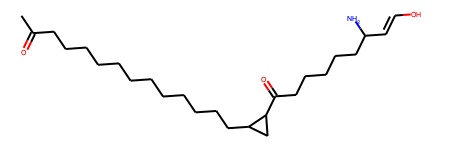

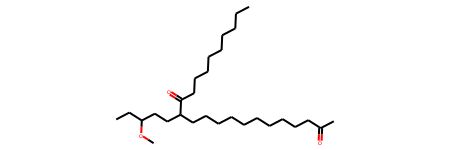

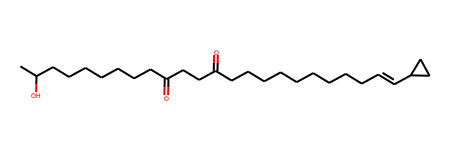

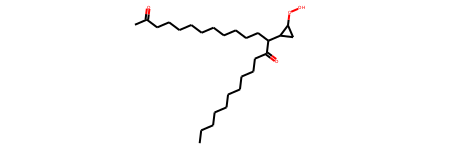

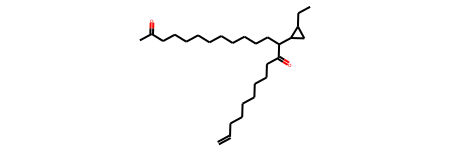

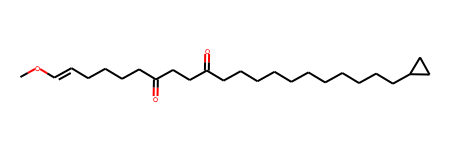

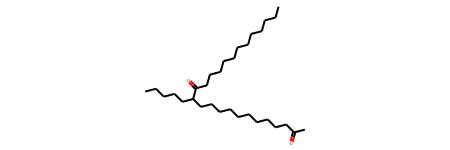

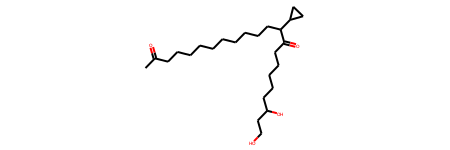

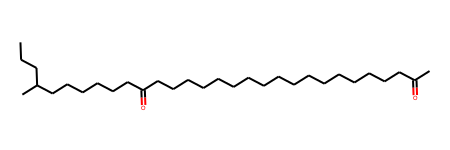

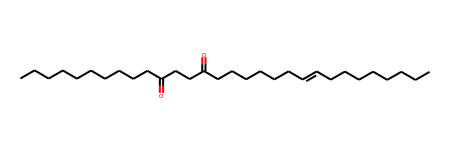

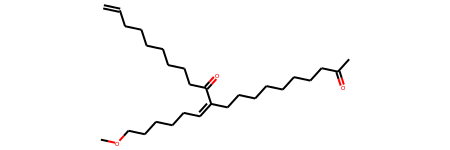

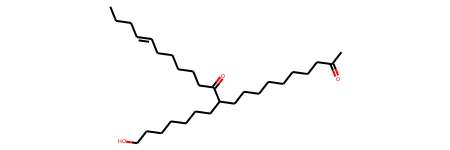

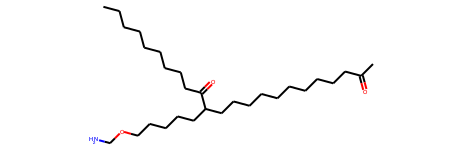

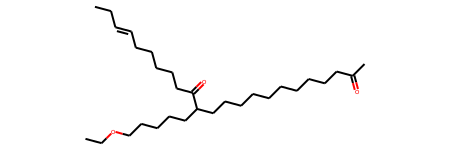

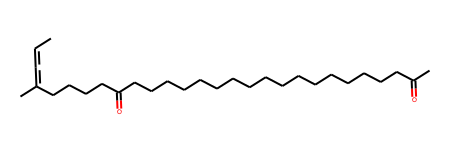

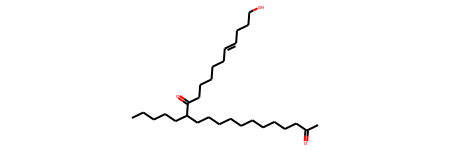

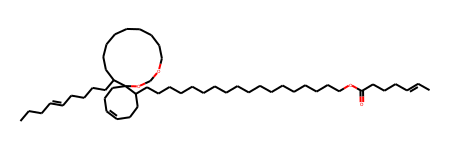

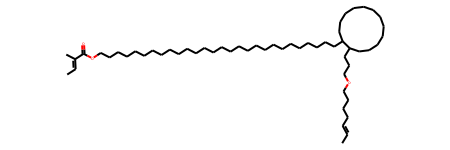

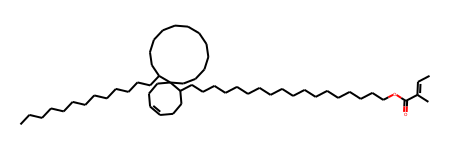

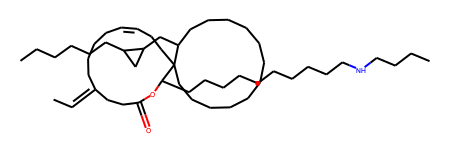

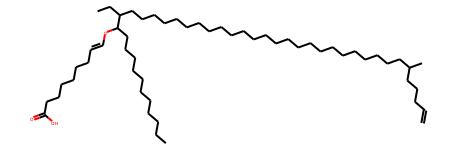

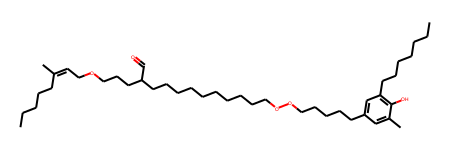

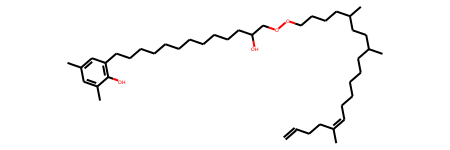

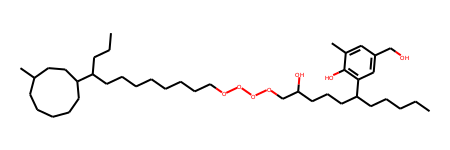

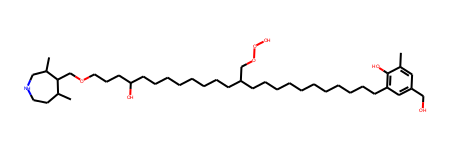

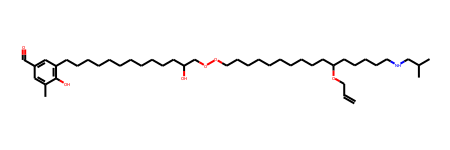

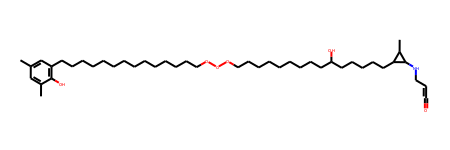

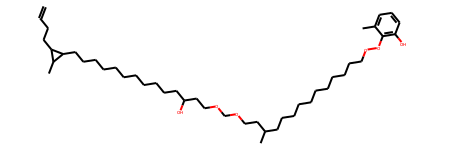

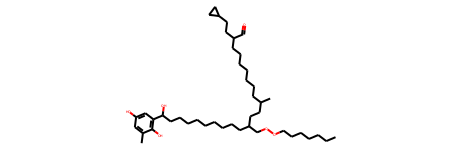

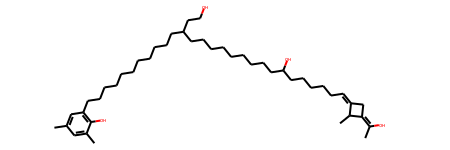

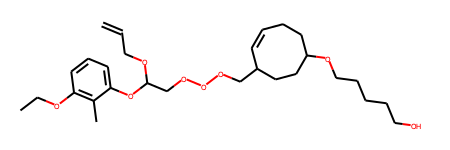

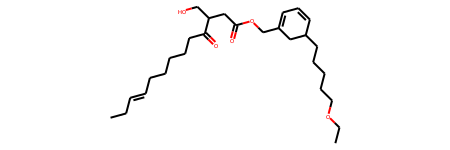

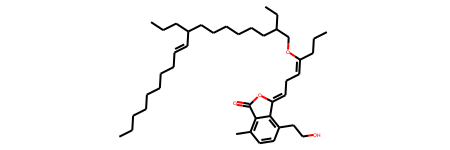

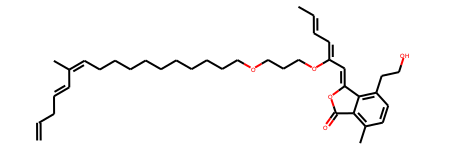

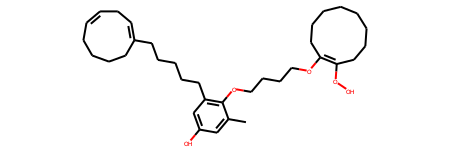

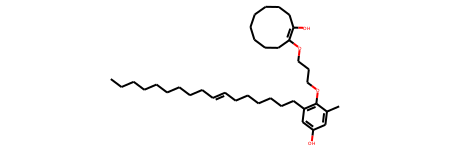

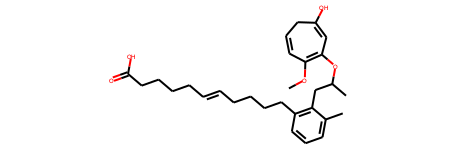

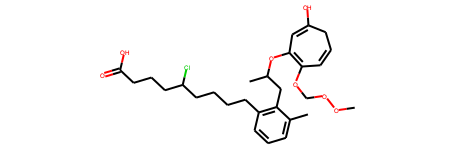

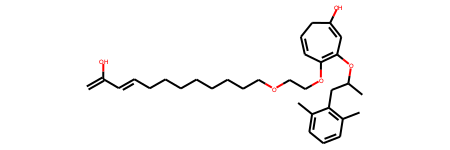

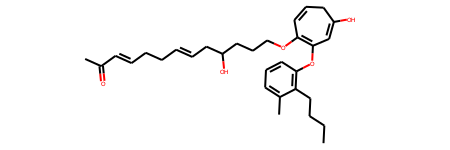

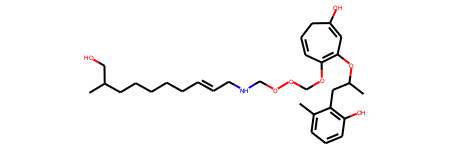

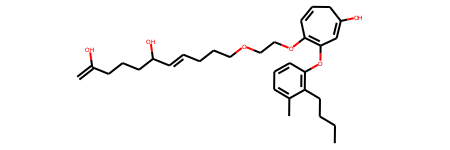

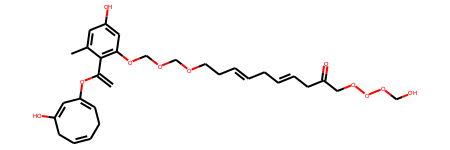

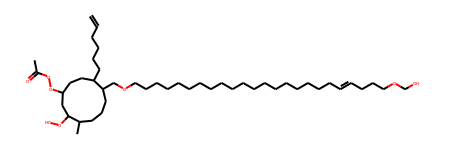

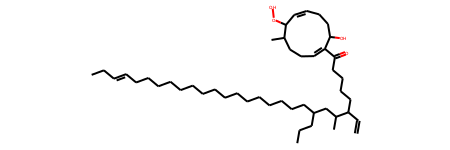

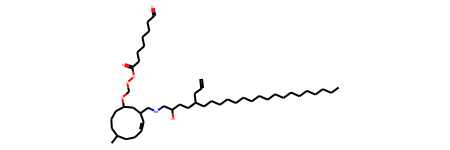

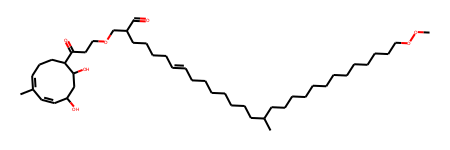

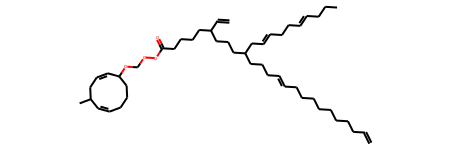

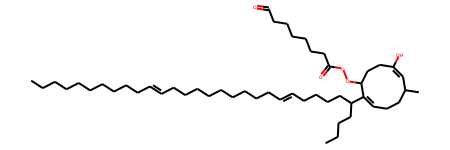

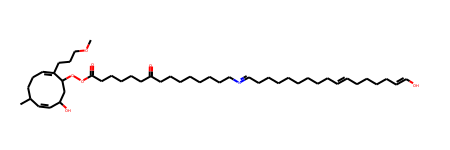

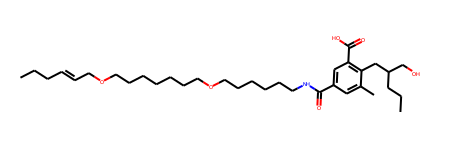

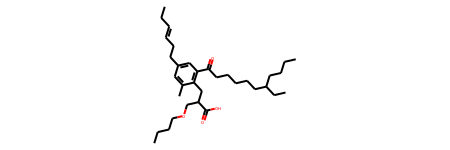

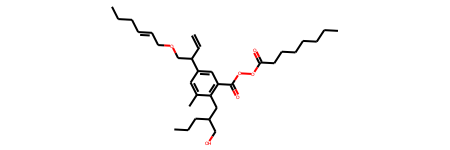

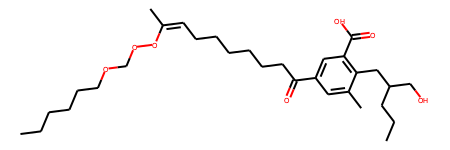

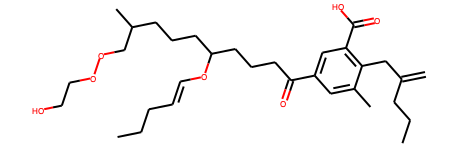

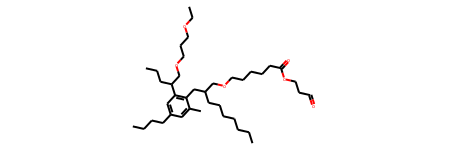

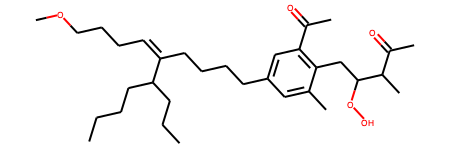

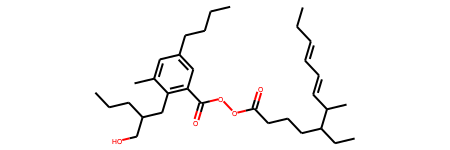

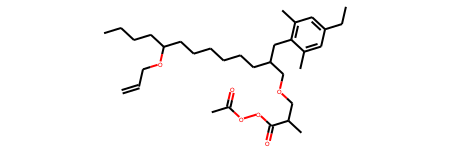

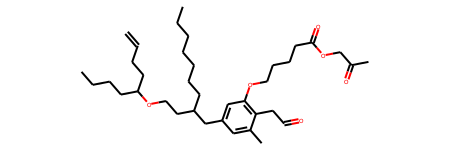

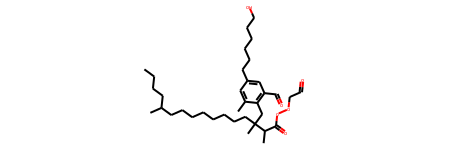

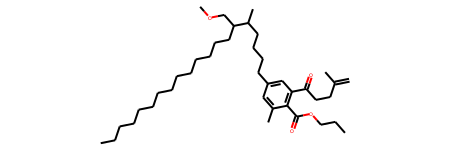

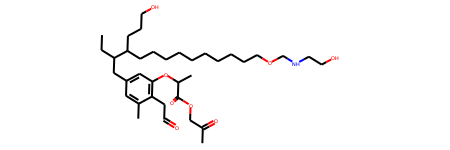

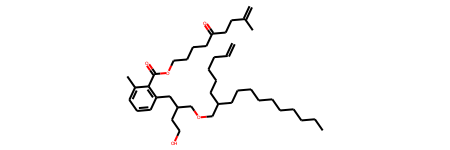

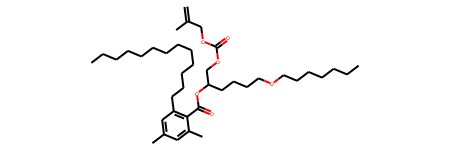

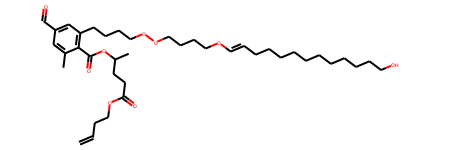

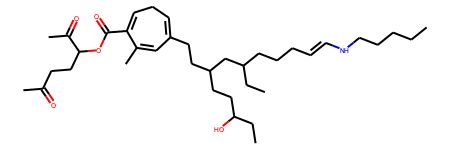

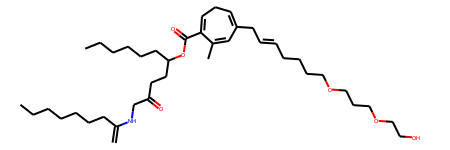

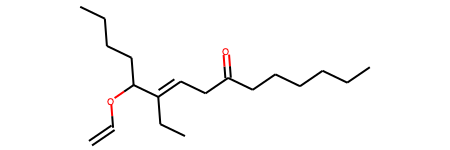

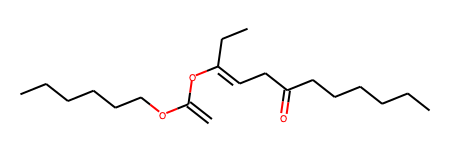

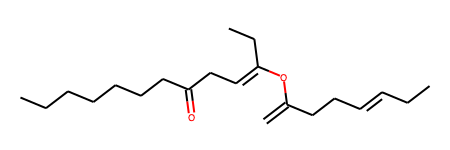

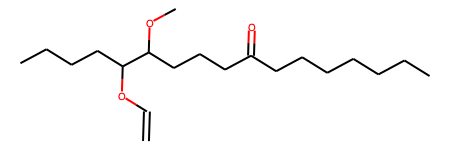

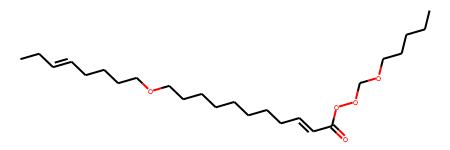

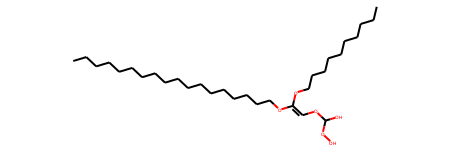

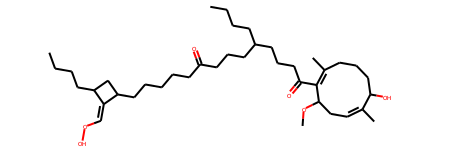

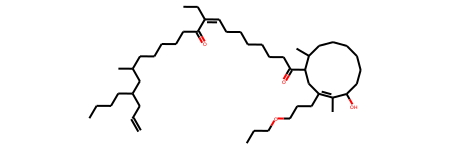

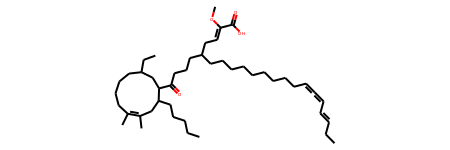

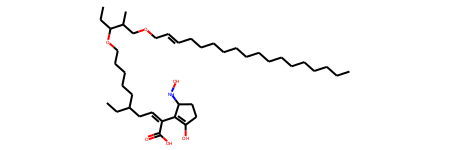

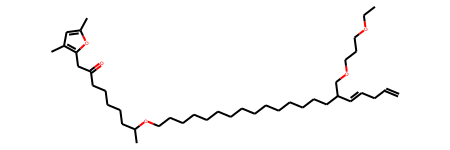

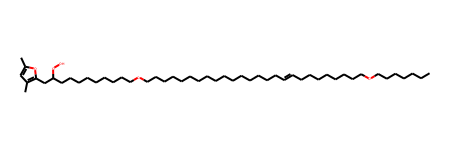

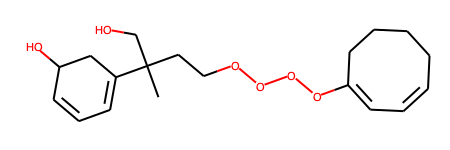

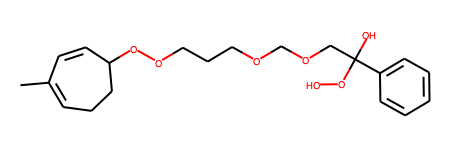

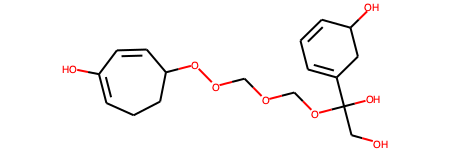

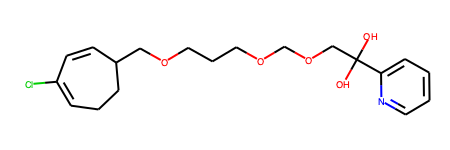

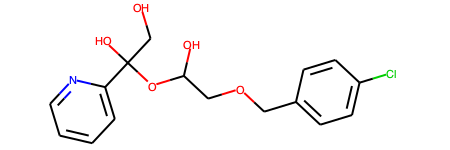

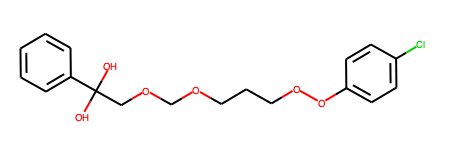

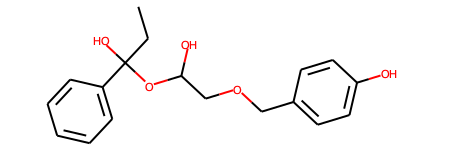

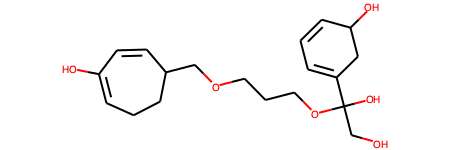

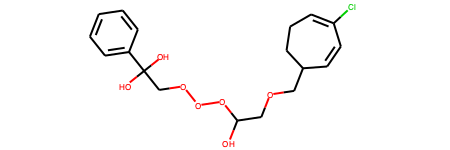

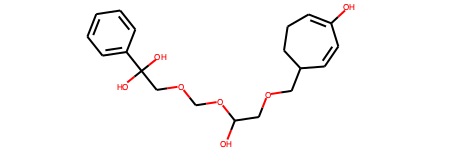

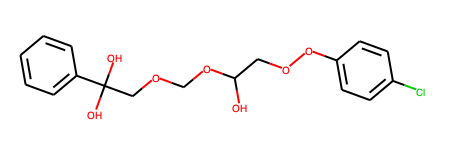

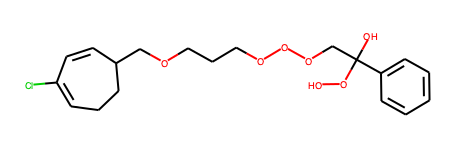

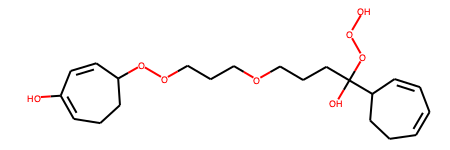

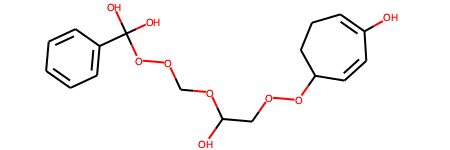

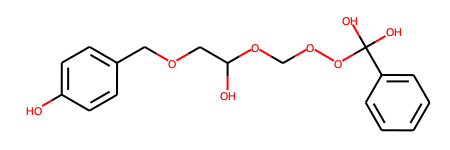

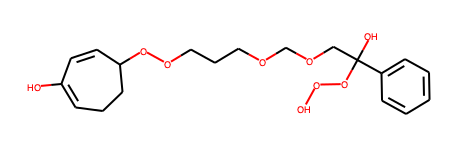

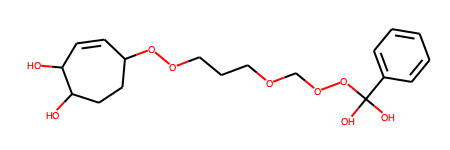

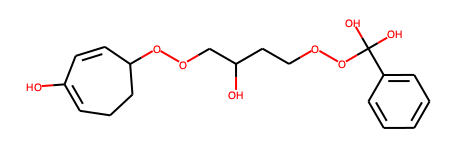

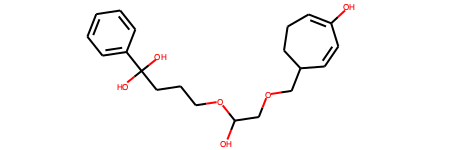

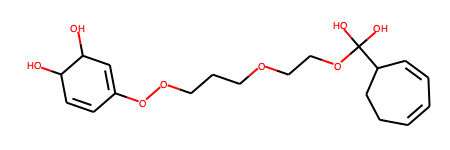

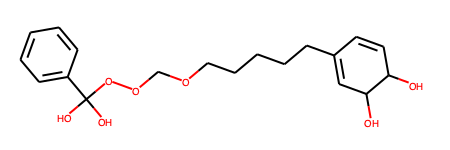

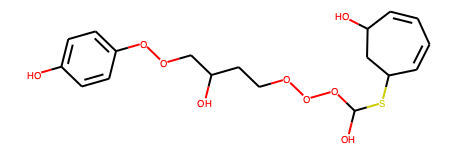

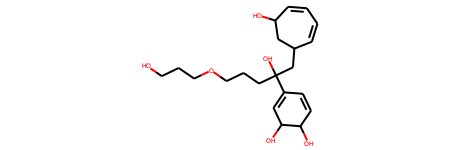

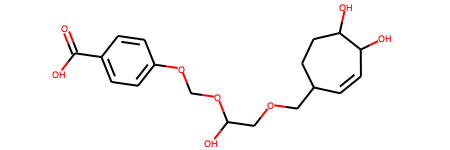

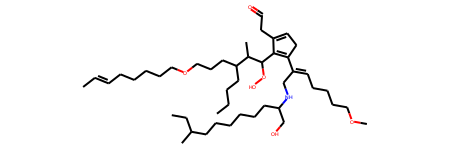

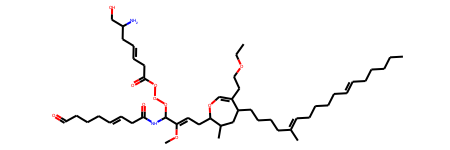

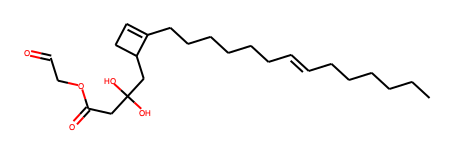

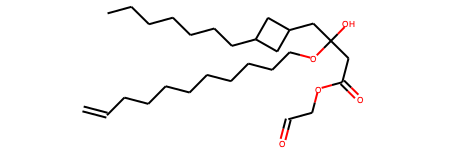

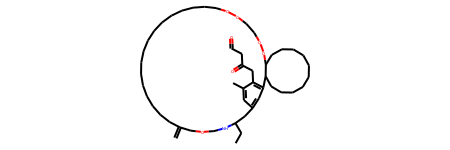

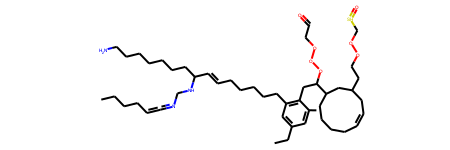

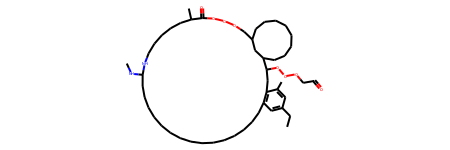

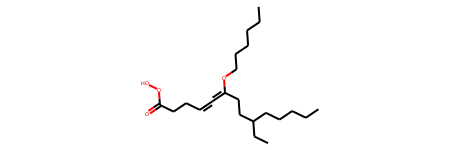

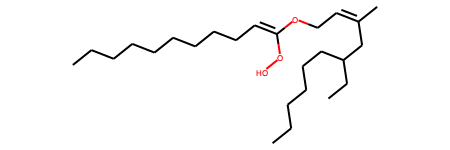

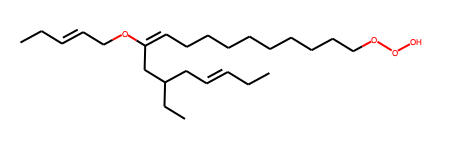

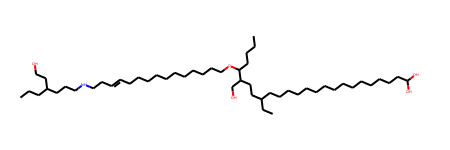

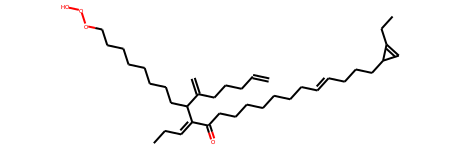

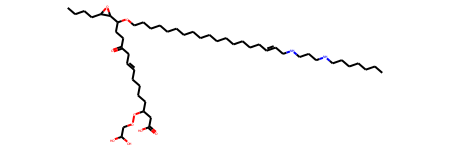

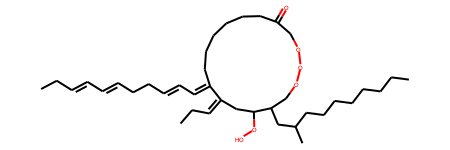

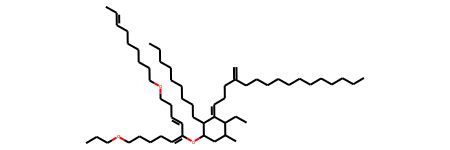

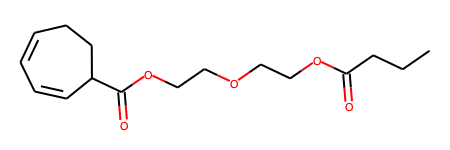

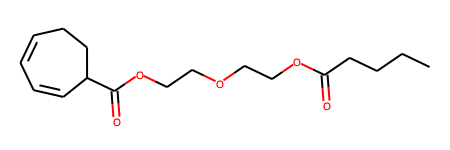

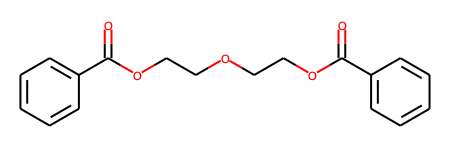

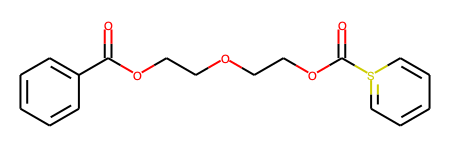

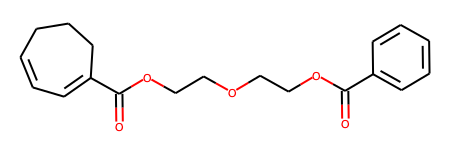

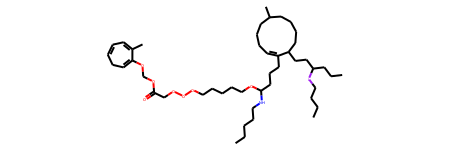

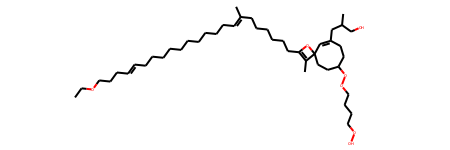

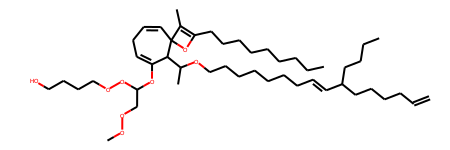

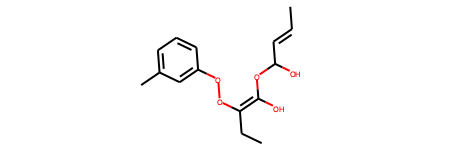

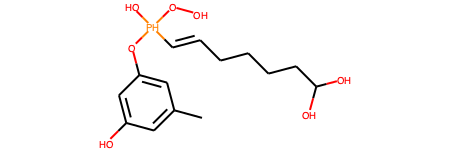

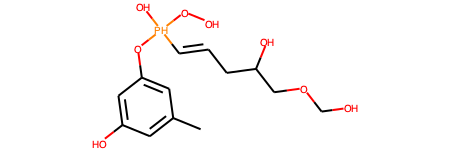

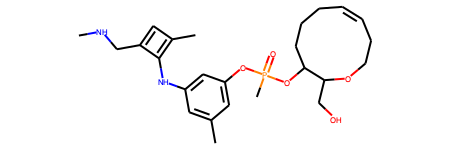

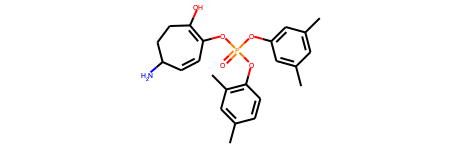

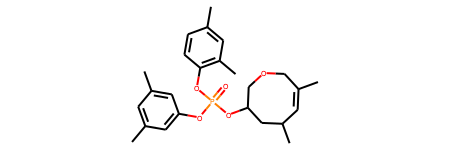

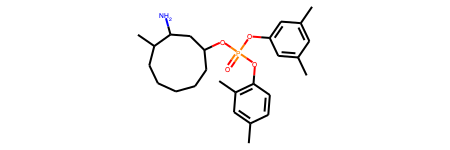

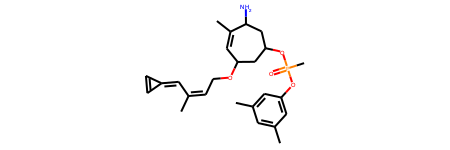

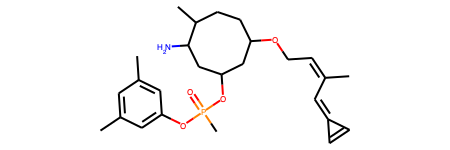

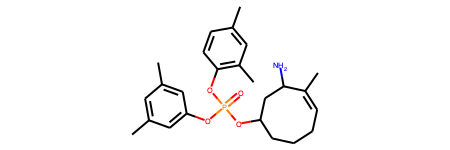

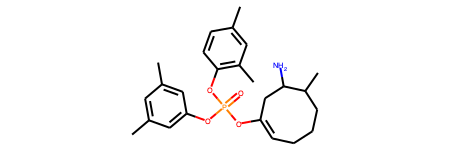

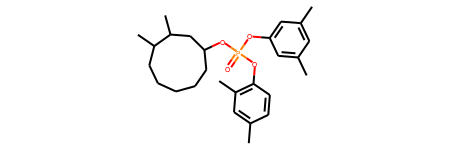

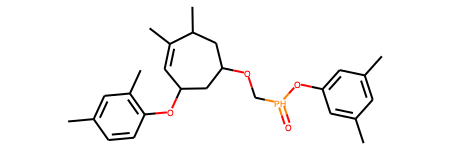

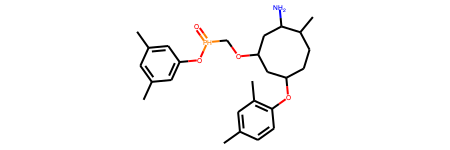

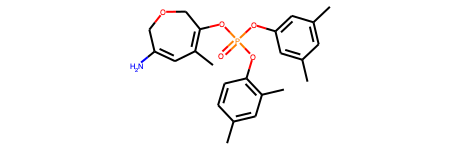

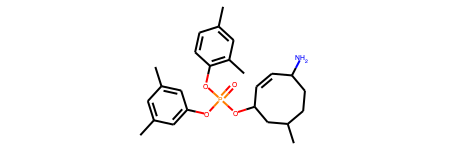

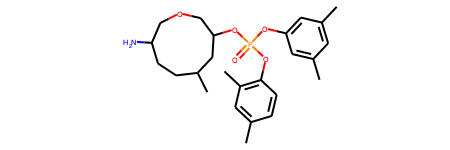

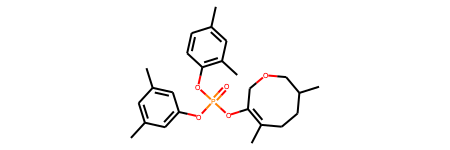

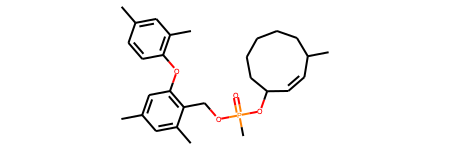

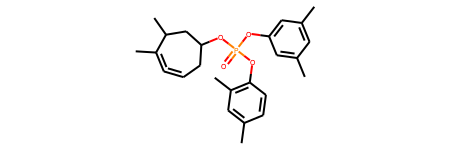

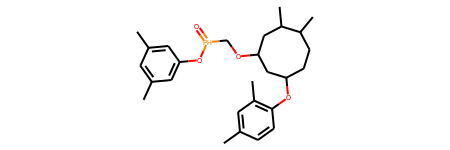

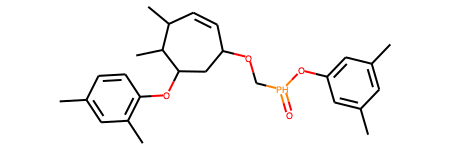

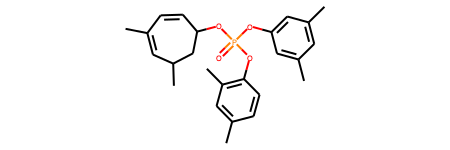

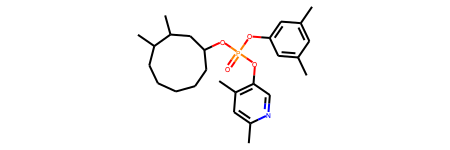

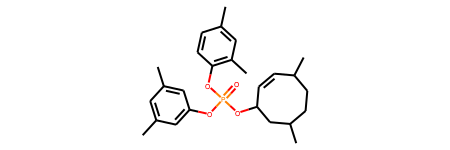

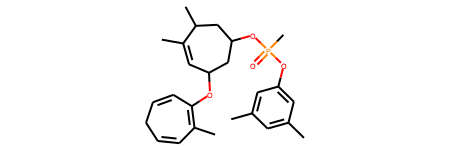

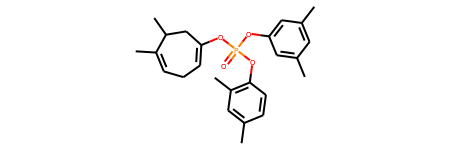

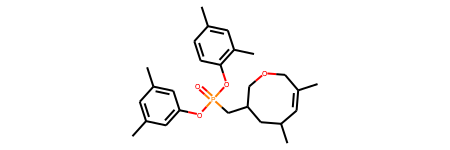

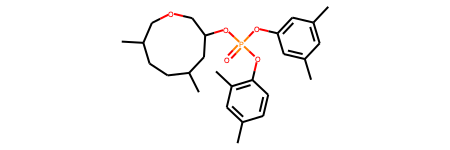

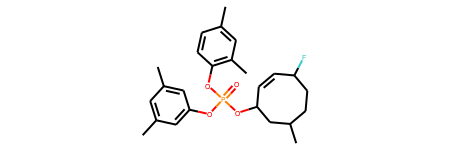

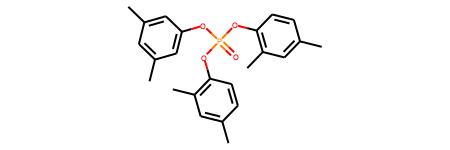

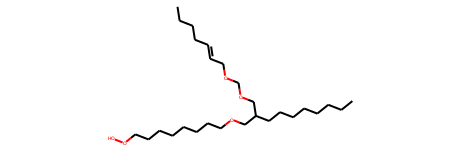

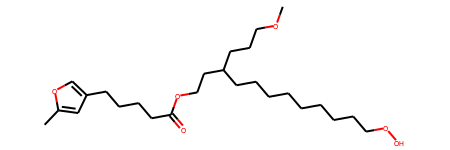

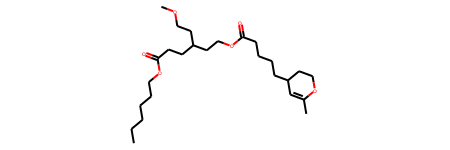

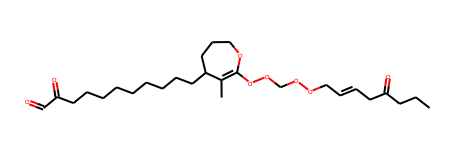

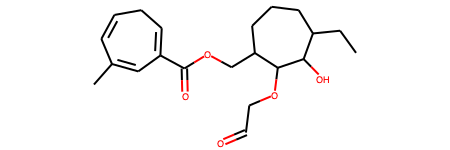

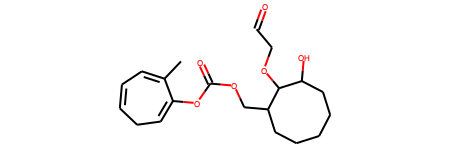

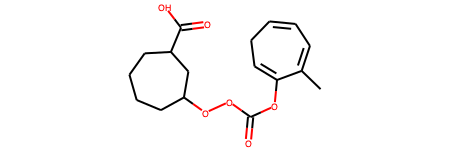

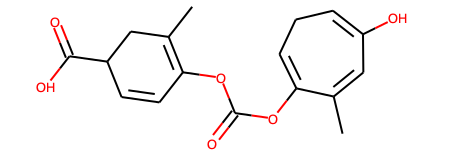

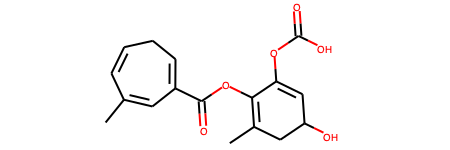

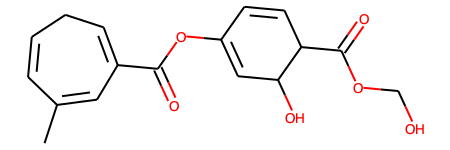

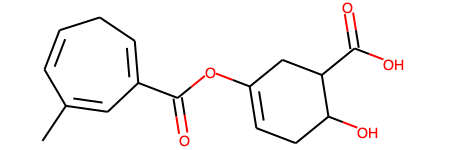

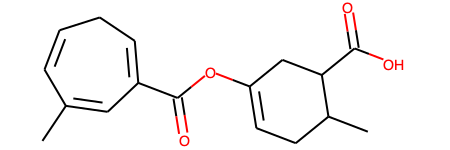

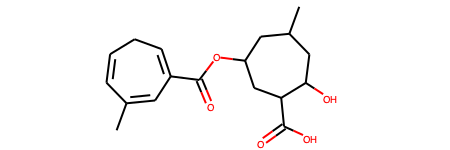

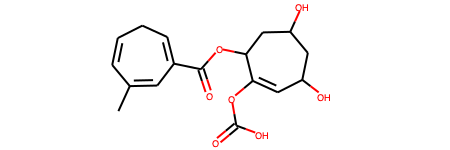

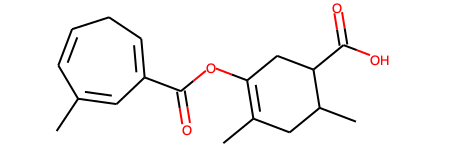

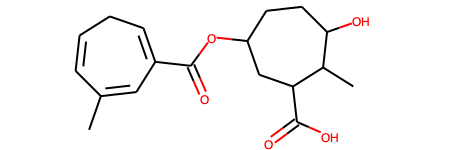

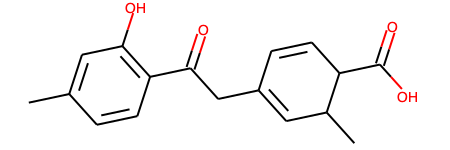

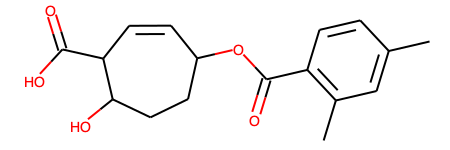

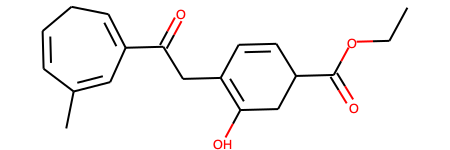

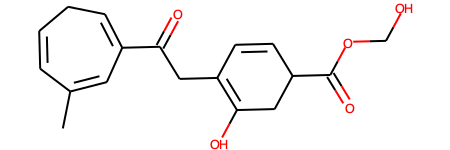

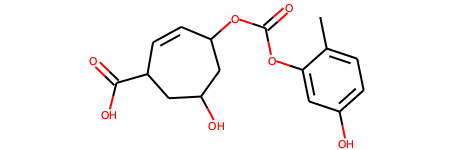

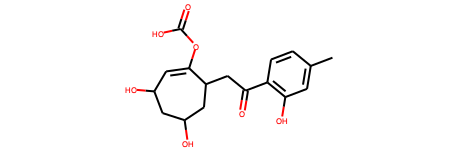

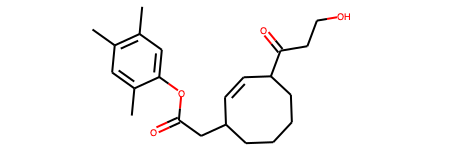

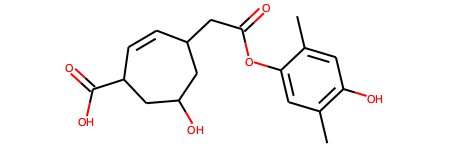

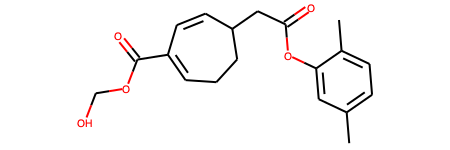

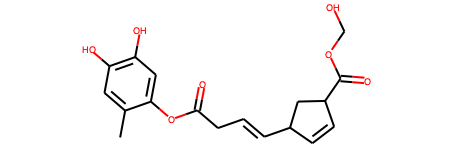

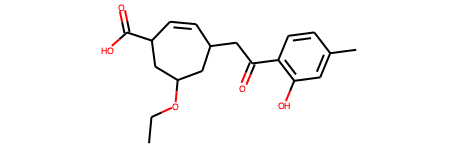

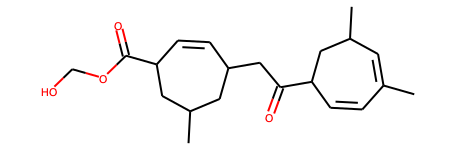

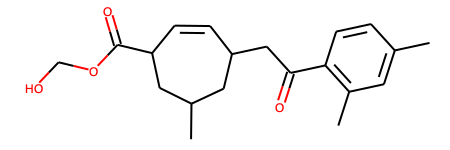

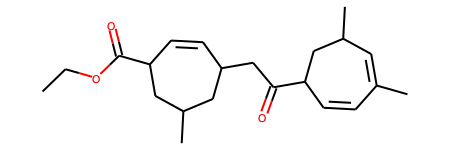

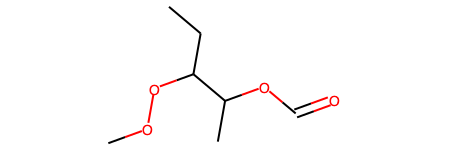

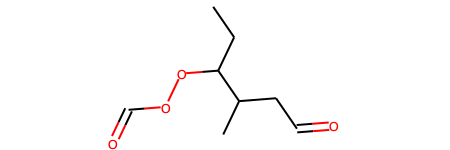

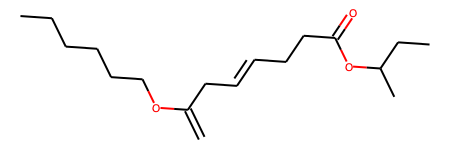

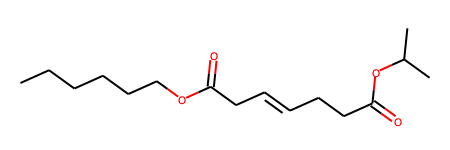

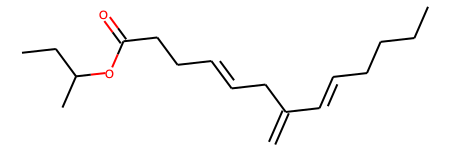

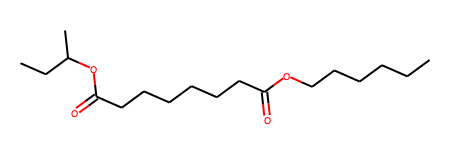

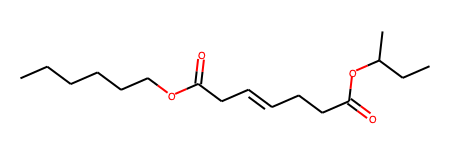

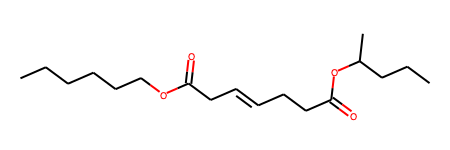

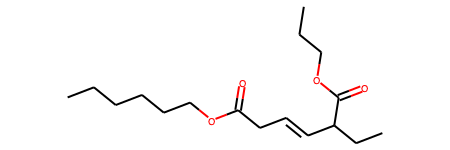

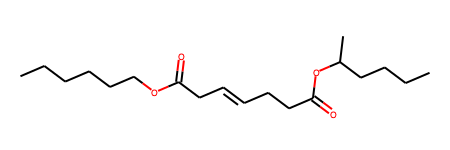

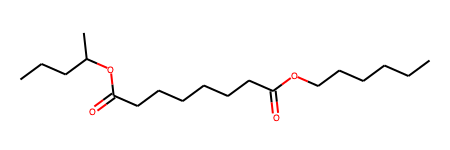

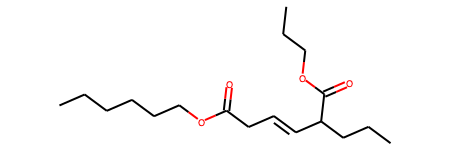

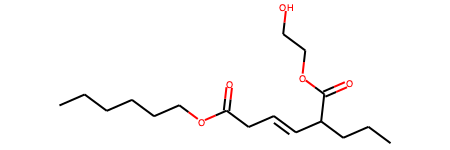

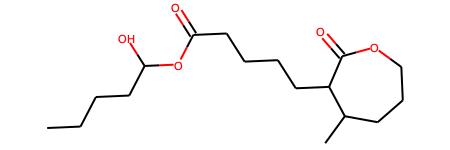

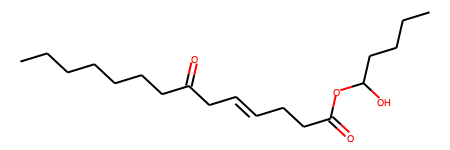

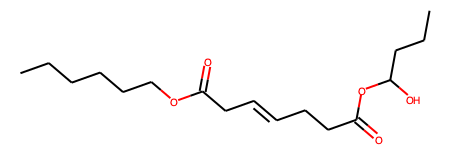

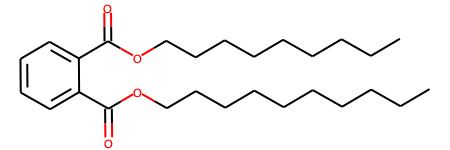

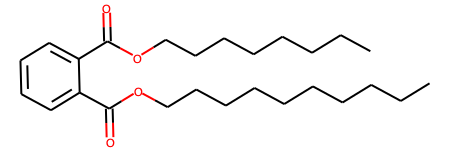

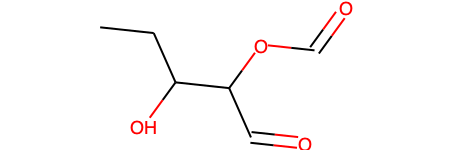

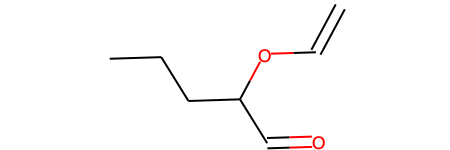

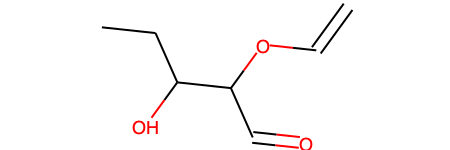

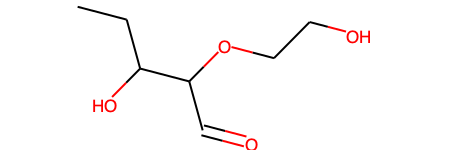

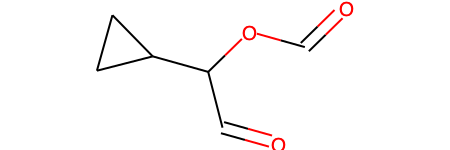

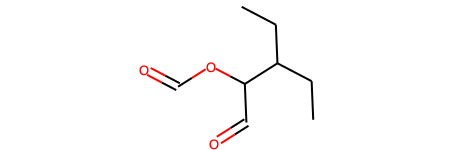

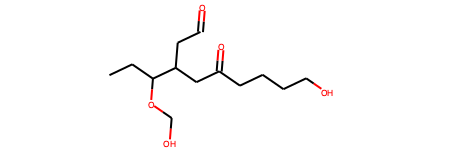

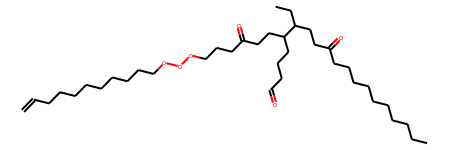

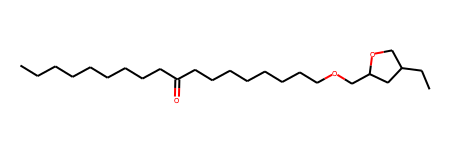

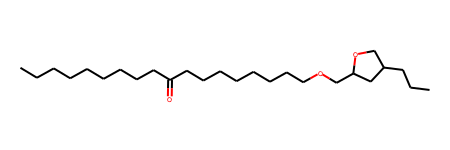

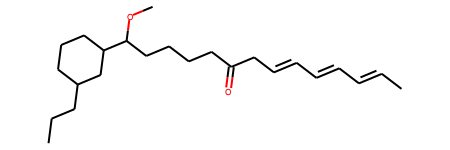

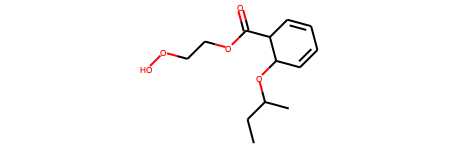

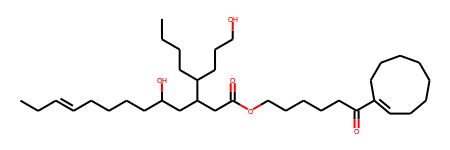

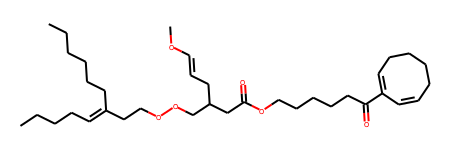

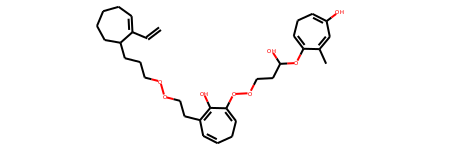

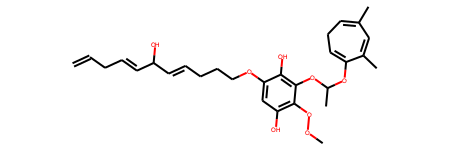

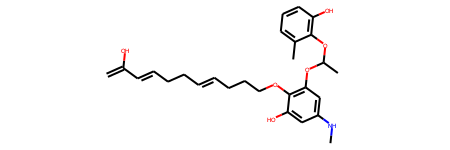

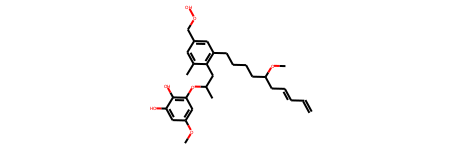

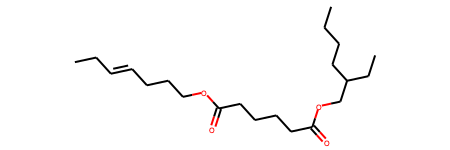

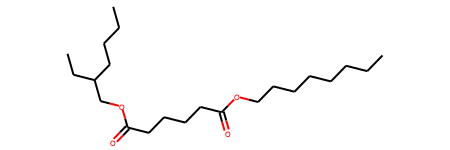

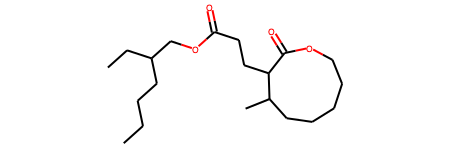

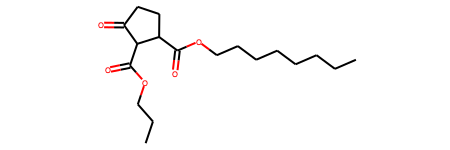

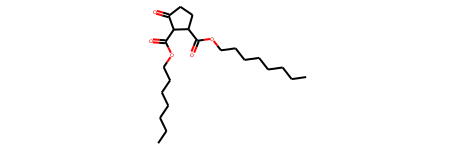

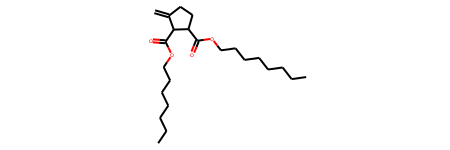

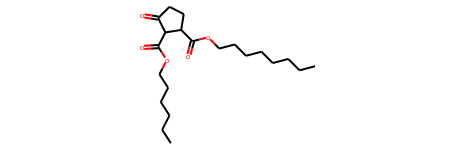

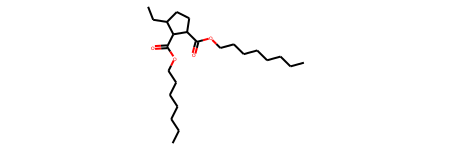

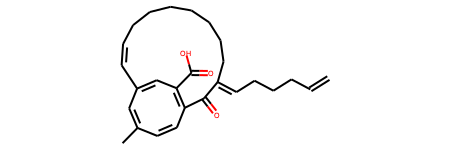

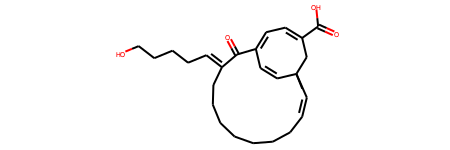

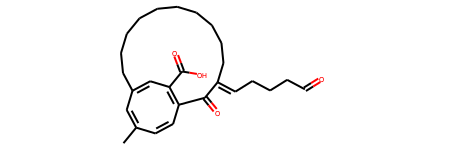

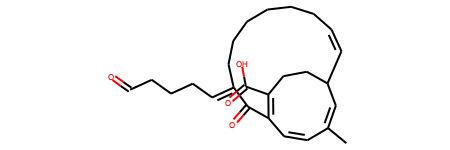

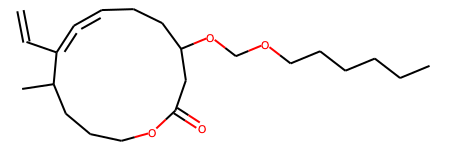

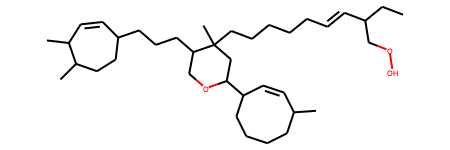

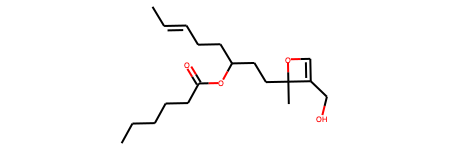

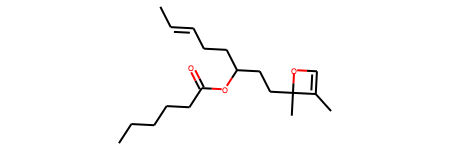

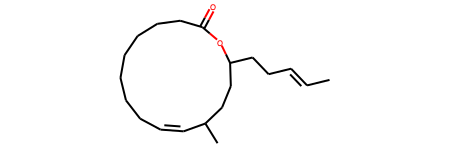

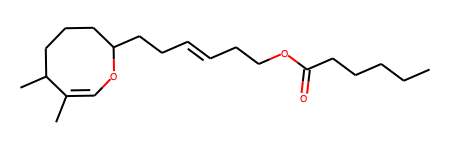

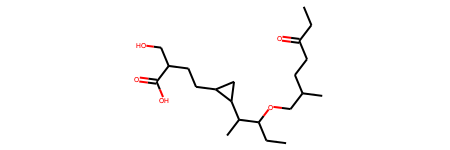

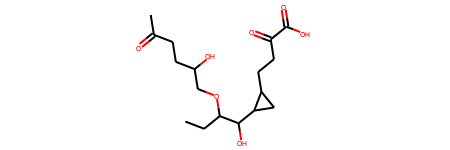

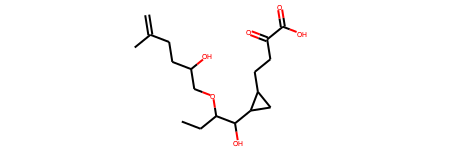

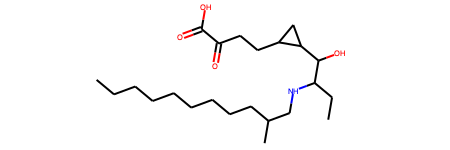

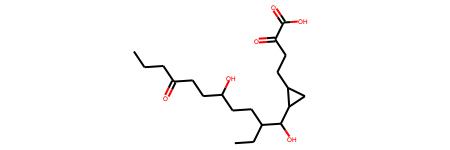

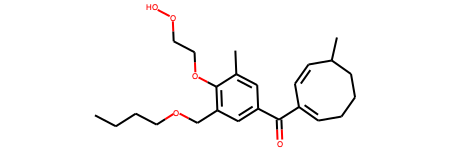

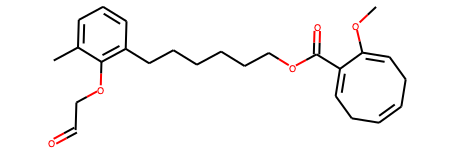

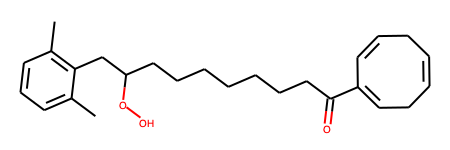

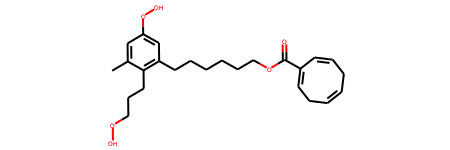

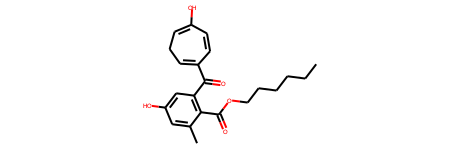

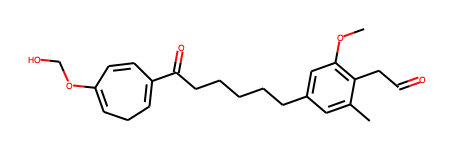

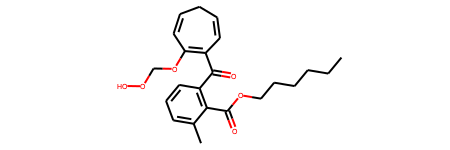

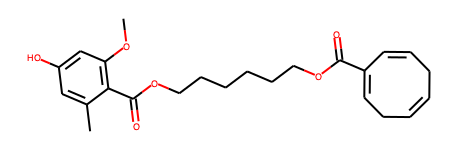

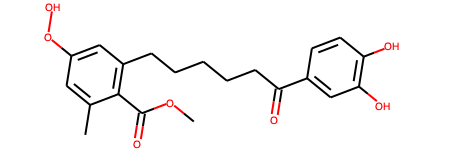

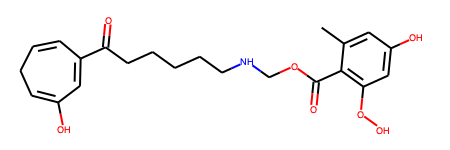

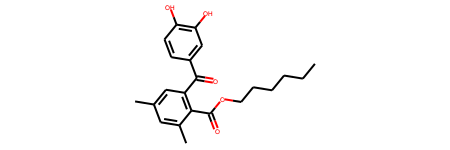

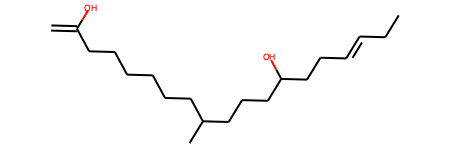

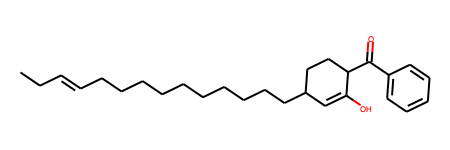

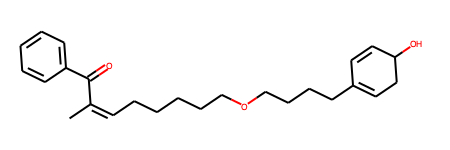

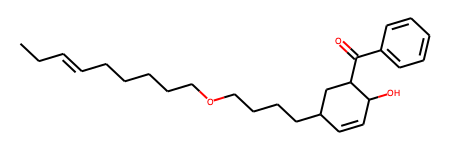

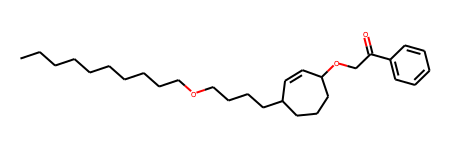

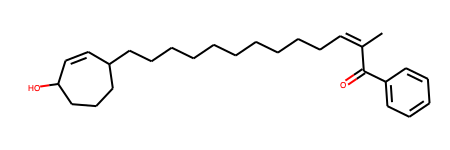

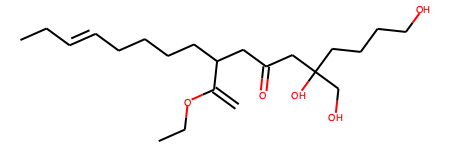

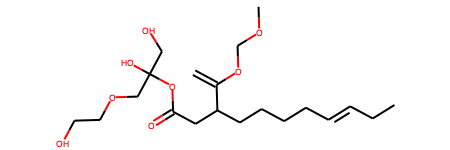

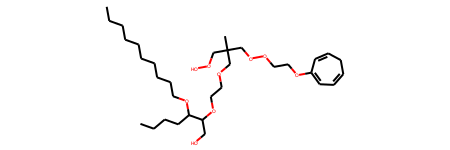

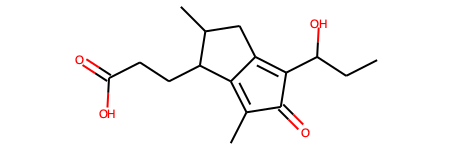

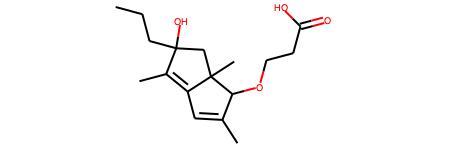

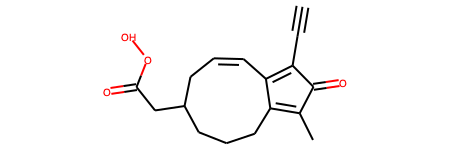

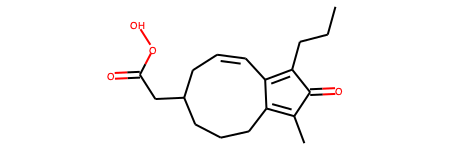

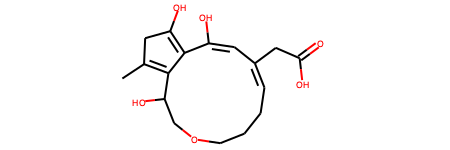

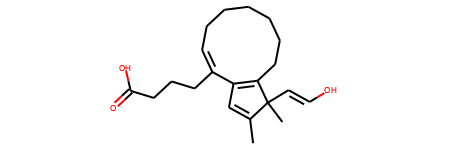

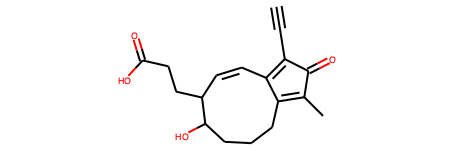

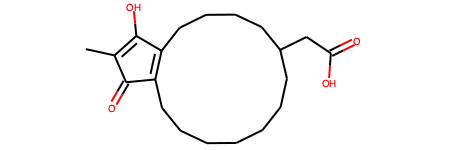

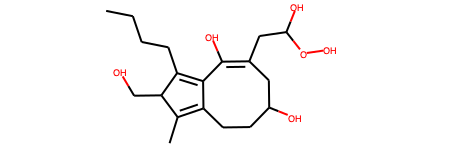

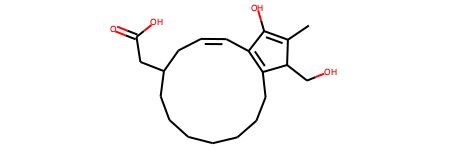

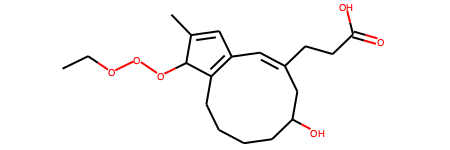

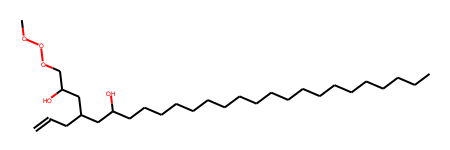

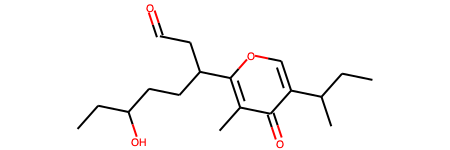

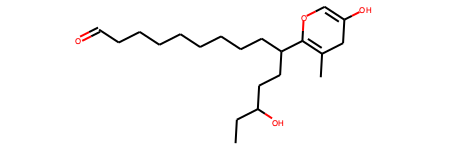

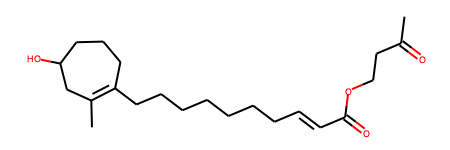

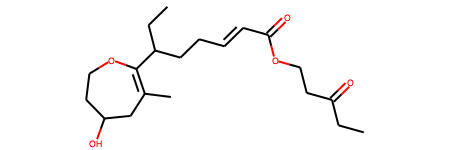

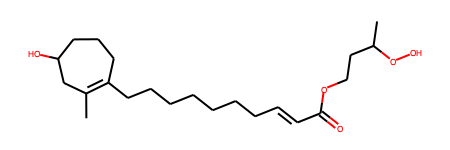

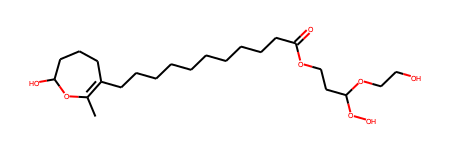

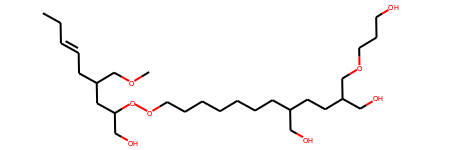

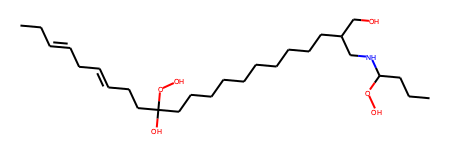

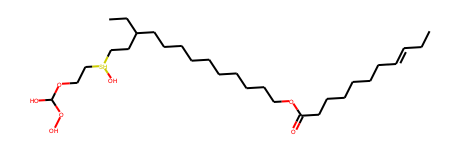

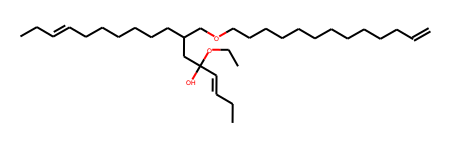

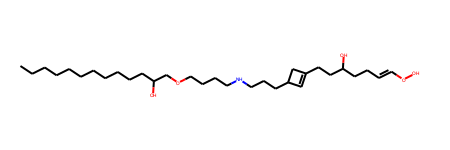

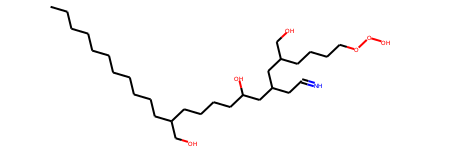

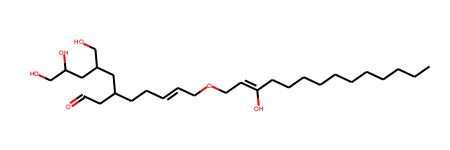

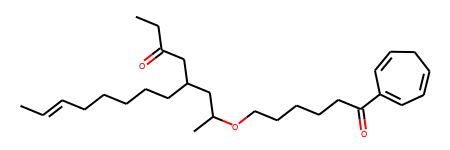

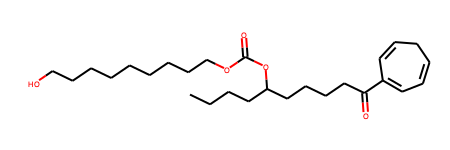

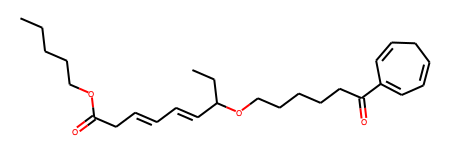

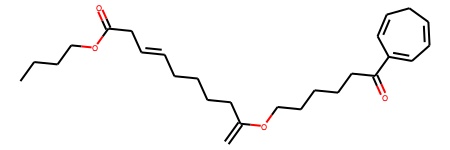

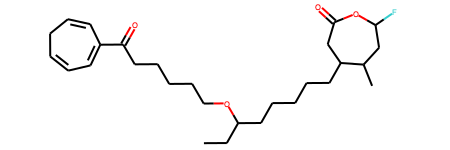

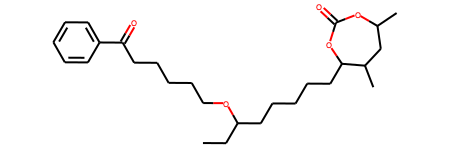

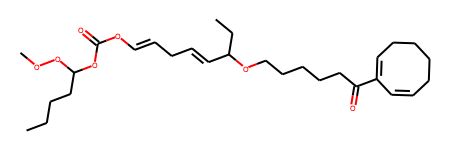

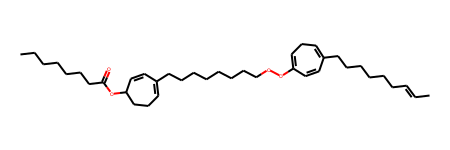

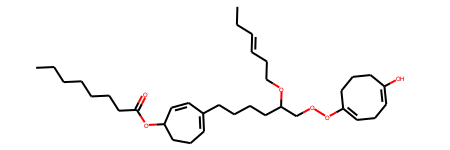

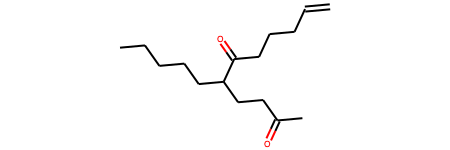

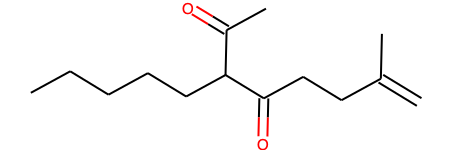

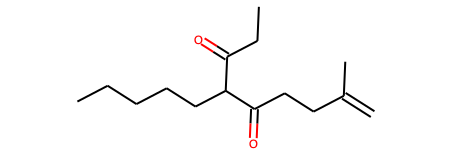

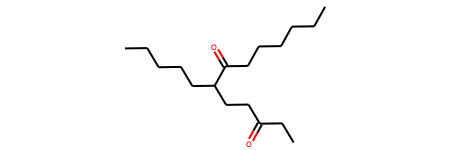

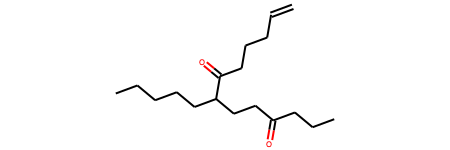

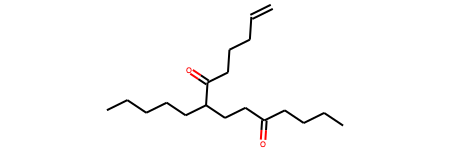

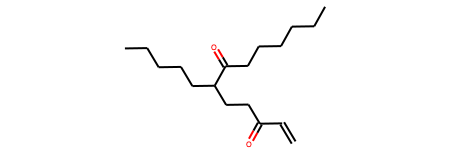

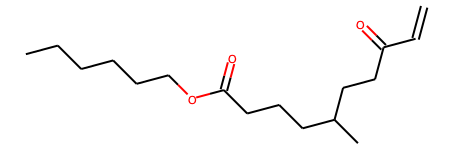

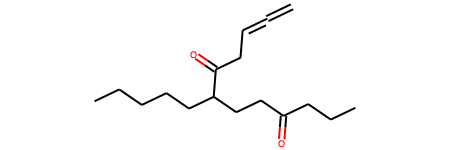

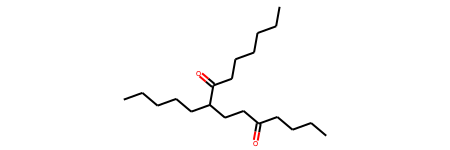

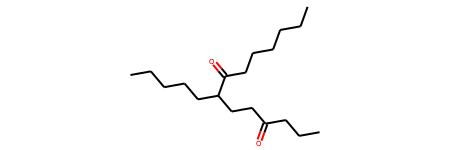

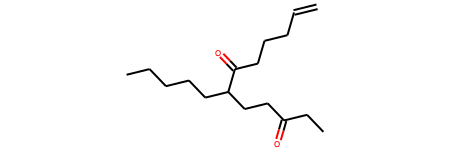

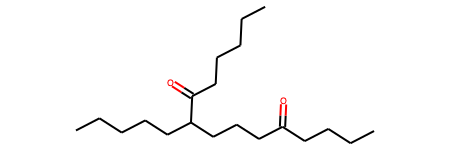

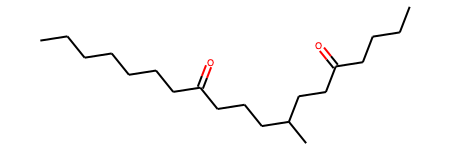

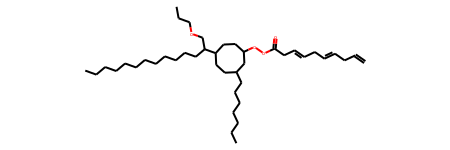

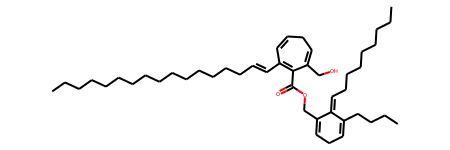

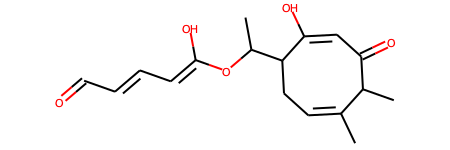

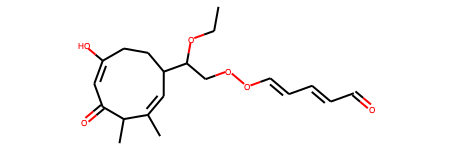

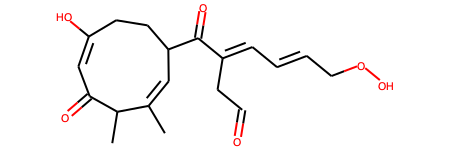

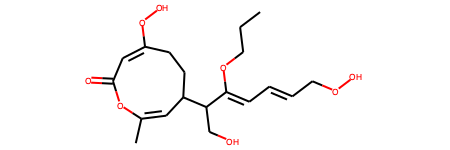

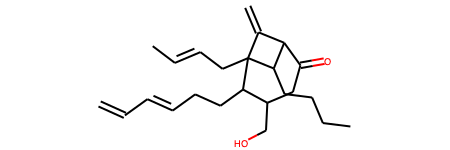

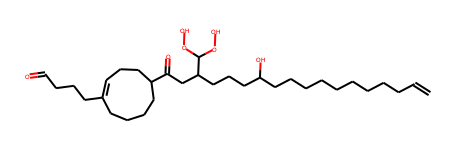

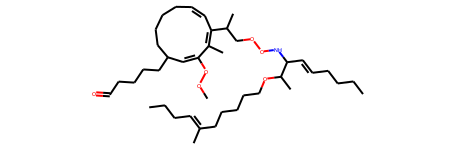

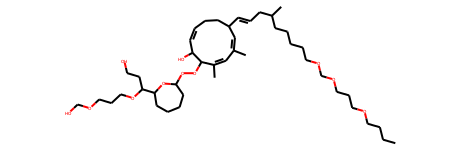

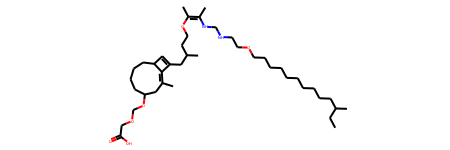

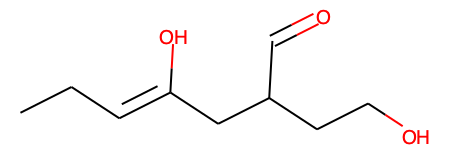

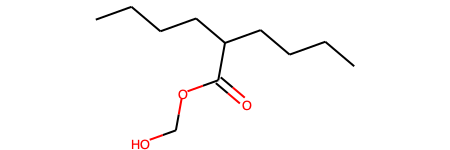

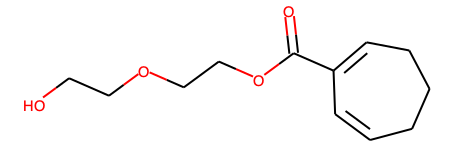

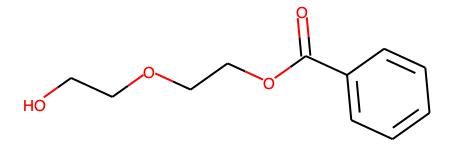

In [103]:
for i in range(len(mols)):
    display(mols[i])